# PROJET 5 - PRODUISEZ UNE ÉTUDE DE MARCHÉ

## Mise en situation

Votre entreprise d'agroalimentaire souhaite se développer à l'international. Elle est spécialisée dans le **poulet**.  
L'international, oui, mais pour l'instant, le champ des possibles est bien large : _aucun pays particulier ni aucun continent n'est pour le moment choisi_. Tous les pays sont envisageables !  
Votre objectif sera d'aider à **cibler plus particulièrement certains pays**, dans le but d'approfondir ensuite l'étude de marché. Plus particulièrement, l'idéal serait de _produire des "groupes" de pays, plus ou moins gros, dont on connaît les caractéristiques_.
Dans un premier temps, la stratégie est plutôt d'**exporter les produits** plutôt que de produire sur place, c'est-à-dire dans le(s) nouveau(x) pays ciblé(s).

## Importation des modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.mlab as mlab
import seaborn as sns
import matplotlib.patches as mpatches

from scipy.stats import ks_2samp
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition, preprocessing

import scipy as st
import scipy.stats as stats
from scipy.stats import fligner
from scipy.stats import shapiro

import geopandas as gpd
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, FixedTicker
from bokeh.palettes import brewer

## Paramétrage de l'environnement de travail

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                      plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

## Chargement des données

In [3]:
%pwd

'/Users/anissa'

In [4]:
%cd /Users/anissa/P5

/Users/anissa/P5


In [5]:
securite_alimentaire = pd.read_csv("securite_alimentaire.csv")
population = pd.read_csv("population.csv")
bilans_alimentaires = pd.read_csv("bilans_alimentaires.csv")
ipc = pd.read_csv("ipc.csv")
qte_volailles = pd.read_csv("qte_volailles.csv")
import_volailles = pd.read_csv("import_volailles.csv")

## Exploration des données

***csv bilans_alimentaires***

In [6]:
# On décide de garder les données de la FAO basées sur une méthodologie d'imputation et donnée calculé
bilans_alim = bilans_alimentaires.loc[bilans_alimentaires["Symbole"]!="A"]

# On supprime la Chine (redondance)
bilans_alim = bilans_alim.loc[bilans_alim["Zone"]!="Chine"]

# On supprime Soudan car nous n'avons pas les informations nécessaires
bilans_alim = bilans_alim.loc[bilans_alim["Zone"]!="Soudan"]

# On supprime également la France
bilans_alim = bilans_alim.loc[bilans_alim["Zone"]!="France"]

bilans_alim.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),2901,Total General,2018,2018,Kcal/personne/jour,2040.00,Fc,Donnée calculée
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,674,Disponibilité de protéines en quantité (g/pers...,2901,Total General,2018,2018,g/personne/jour,55.52,Fc,Donnée calculée
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),2903,Produits Vegetaux,2018,2018,Kcal/personne/jour,1849.00,Fc,Donnée calculée
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,674,Disponibilité de protéines en quantité (g/pers...,2903,Produits Vegetaux,2018,2018,g/personne/jour,44.73,Fc,Donnée calculée
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),2941,Produits Animaux,2018,2018,Kcal/personne/jour,191.00,Fc,Donnée calculée


***csv population***

In [7]:
# On décide de ne garder que les sources internationales sûres
pop = population.loc[population["Description du Symbole"]=="Sources internationales sûres"]

# On garde les données de la population totale
population_totale = pop.loc[pop["Élément"]=="Population totale"]

# On garde les données de la population totale
population_totale = pop.loc[pop["Élément"]=="Population totale"]

# On supprime le Soudan
population_totale = population_totale.loc[population_totale["Zone"]!="Soudan"]

# On supprime les données de la France
population_totale = population_totale.loc[population_totale["Zone"]!="France"]

population_totale.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2010,2010,1000 personnes,29185.507,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,37171.921,X,Sources internationales sûres,NaN
6,OA,Séries temporelles annuelles,202,Afrique du Sud,511,Population totale,3010,Population-Estimations,2010,2010,1000 personnes,51216.964,X,Sources internationales sûres,NaN
9,OA,Séries temporelles annuelles,202,Afrique du Sud,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,57792.518,X,Sources internationales sûres,NaN
12,OA,Séries temporelles annuelles,3,Albanie,511,Population totale,3010,Population-Estimations,2010,2010,1000 personnes,2948.023,X,Sources internationales sûres,NaN


***csv securite_alimentaire***

In [8]:
# On supprime la colonne "Note"
del securite_alimentaire['Note']

# On supprime les données de la Chine (redondance)
securite_alimentaire = securite_alimentaire.loc[securite_alimentaire["Zone"]!="Chine"]

# On supprime le Soudan pour manque d'informations
securite_alimentaire = securite_alimentaire.loc[securite_alimentaire["Zone"]!="Soudan"]

# On supprime la France
securite_alimentaire = securite_alimentaire.loc[securite_alimentaire["Zone"]!="France"]

securite_alimentaire.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FS,Données de la sécurité alimentaire,2,Afghanistan,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2018,2018,I$,2190.20,X,Sources internationales sûres
1,FS,Données de la sécurité alimentaire,2,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2018,2018,indice,-2.75,X,Sources internationales sûres
2,FS,Données de la sécurité alimentaire,202,Afrique du Sud,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2018,2018,I$,12630.80,X,Sources internationales sûres
3,FS,Données de la sécurité alimentaire,202,Afrique du Sud,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2018,2018,indice,-0.28,X,Sources internationales sûres
4,FS,Données de la sécurité alimentaire,3,Albanie,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2018,2018,I$,13601.30,X,Sources internationales sûres


***csv import_volailles***

In [9]:
# On supprime la Chine (redondance)
import_volailles = import_volailles.loc[import_volailles["Zone"]!="Chine"]

# On supprime Soudan car nous n'avons pas les informations nécessaires
import_volailles = import_volailles.loc[import_volailles["Zone"]!="Soudan"]

# On supprime les données de la France (déjà implanté)
import_volailles = import_volailles.loc[import_volailles["Zone"]!="France"]

import_volailles.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2734,Viande de Volailles,2018,2018,Milliers de tonnes,25,Im,Données de la FAO basées sur une méthodologie ...
1,FBS,Nouveaux Bilans Alimentaire,202,Afrique du Sud,5611,Importations - Quantité,2734,Viande de Volailles,2018,2018,Milliers de tonnes,515,Im,Données de la FAO basées sur une méthodologie ...
2,FBS,Nouveaux Bilans Alimentaire,3,Albanie,5611,Importations - Quantité,2734,Viande de Volailles,2018,2018,Milliers de tonnes,12,Im,Données de la FAO basées sur une méthodologie ...
3,FBS,Nouveaux Bilans Alimentaire,4,Algérie,5611,Importations - Quantité,2734,Viande de Volailles,2018,2018,Milliers de tonnes,0,Im,Données de la FAO basées sur une méthodologie ...
4,FBS,Nouveaux Bilans Alimentaire,79,Allemagne,5611,Importations - Quantité,2734,Viande de Volailles,2018,2018,Milliers de tonnes,871,Im,Données de la FAO basées sur une méthodologie ...


***csv qte_volailles***

In [10]:
# On supprime la Chine (redondance)
qte_volailles = qte_volailles.loc[qte_volailles["Zone"]!="Chine"]

# On supprime Soudan car nous n'avons pas les informations nécessaires
qte_volailles = qte_volailles.loc[qte_volailles["Zone"]!="Soudan"]

# On supprime les données de la France
qte_volailles = qte_volailles.loc[qte_volailles["Zone"]!="France"]

qte_volailles.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2018,2018,kg,1.43,Fc,Donnée calculée
1,FBS,Nouveaux Bilans Alimentaire,202,Afrique du Sud,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2018,2018,kg,38.57,Fc,Donnée calculée
2,FBS,Nouveaux Bilans Alimentaire,3,Albanie,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2018,2018,kg,9.48,Fc,Donnée calculée
3,FBS,Nouveaux Bilans Alimentaire,4,Algérie,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2018,2018,kg,6.98,Fc,Donnée calculée
4,FBS,Nouveaux Bilans Alimentaire,79,Allemagne,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2018,2018,kg,18.15,Fc,Donnée calculée


***csv ipc***

In [11]:
# On supprime la Chine (redondance)
ipc = ipc.loc[ipc["Zone"]!="Chine"]

# On supprime Soudan car nous n'avons pas les informations nécessaires
ipc = ipc.loc[ipc["Zone"]!="Soudan"]

# On supprime la France
ipc = ipc.loc[ipc["Zone"]!="France"]

ipc.head()

,Code Domaine,Domaine,Code zone,Zone,Code année,Année,Code Produit,Produit,Code Mois,Mois,Unité,Valeur,Symbole,Description du Symbole,Note
0,CP,Indices de Prix à la Consommation,2,Afghanistan,2018,2018,23014,Food price inflation,7001,Janvier,%,5.536005,Fc,Donnée calculée,NaN
1,CP,Indices de Prix à la Consommation,2,Afghanistan,2018,2018,23014,Food price inflation,7002,Février,%,4.356706,Fc,Donnée calculée,NaN
2,CP,Indices de Prix à la Consommation,2,Afghanistan,2018,2018,23014,Food price inflation,7003,Mars,%,-1.623142,Fc,Donnée calculée,NaN
3,CP,Indices de Prix à la Consommation,2,Afghanistan,2018,2018,23014,Food price inflation,7004,Avril,%,-2.562263,Fc,Donnée calculée,NaN
4,CP,Indices de Prix à la Consommation,2,Afghanistan,2018,2018,23014,Food price inflation,7005,Mai,%,-3.630195,Fc,Donnée calculée,NaN


---------

## Analyse I

### 1. Ajout des variables 

_source :_  
* http://www.fao.org/faostat/fr/#data/FBS

#### 1.1. _Variables disponibilité alimentaire en kcal_ et _disponibilité de protéines_

In [12]:
# On effectue une table pivot de bilans_alim
bm_pays = bilans_alim.loc[bilans_alim["Produit"]=="Total General"]
bil_aliment = pd.pivot_table(bm_pays, index=["Code zone", "Zone", "Produit",
                                              "Année"], 
                                                  columns="Élément", values="Valeur", 
                                                              aggfunc="sum")
bil_alim = bil_aliment.reset_index()
bil_alim = bil_alim[["Code zone", "Zone", "Produit", "Année", 
                     "Disponibilité alimentaire (Kcal/personne/jour)", 
                     "Disponibilité de protéines en quantité (g/personne/jour)"]]

bil_alim.head()

Élément,Code zone,Zone,Produit,Année,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour)
0,1,Arménie,Total General,2018,2997.0,94.35
1,2,Afghanistan,Total General,2018,2040.0,55.52
2,3,Albanie,Total General,2018,3360.0,115.74
3,4,Algérie,Total General,2018,3322.0,91.83
4,7,Angola,Total General,2018,2385.0,53.05


#### 1.2. Variable _croissance de la population_

In [13]:
# On procède à la table pivot du df popul
popul = pd.pivot_table(population_totale, index= ["Code zone", "Zone", 
                                    "Code Produit" ,"Unité"], 
                                    columns="Année", values="Valeur", 
                                            aggfunc="sum")
popul.reset_index()

# On créé une colonne avec le taux d'évolution de la population
popul["evol_population"] = ((popul[2018]-popul[2010])/popul[2010])*100
popul.reset_index()

# On nettoie le df pour pouvoir le joindre avec les données nécessaires
popul = popul.drop(columns=[2010])
popul.reset_index()

# On joint les df
data = pd.merge(bil_alim, popul, on="Zone", how="left")
data.head()

,Code zone,Zone,Produit,Année,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),2018,evol_population
0,1,Arménie,Total General,2018,2997.0,94.35,2951.745,2.586644
1,2,Afghanistan,Total General,2018,2040.0,55.52,37171.921,27.364315
2,3,Albanie,Total General,2018,3360.0,115.74,2882.740,-2.214467
3,4,Algérie,Total General,2018,3322.0,91.83,42228.408,17.374639
4,7,Angola,Total General,2018,2385.0,53.05,30809.787,31.912410


#### 1.3. Variable _proportion de protéines d'origine animale_

In [14]:
data_ok = bilans_alim.loc[bilans_alim["Élément"]=="Disponibilité de protéines en quantité (g/personne/jour)"]

data_ok = pd.pivot_table(data_ok, index=["Code zone", "Zone", "Élément",
                                              "Année"], 
                                                  columns="Produit", values="Valeur", 
                                                              aggfunc="sum")
data_ok = data_ok.reset_index()

del data_ok["Produits Vegetaux"]

# Ratio en %
data_ok['ratio_proteines'] = data_ok['Produits Animaux'] / data_ok['Total General'] * 100

# On effectue la jointure avec les autres df 

# On sélectionne les données nécessaires
col_list = ["Zone", "ratio_proteines"]
tot_prot = data_ok[col_list]

# Jointure
data_ok = pd.merge(data, tot_prot, on="Zone", how="left")


# On renomme les colonnes pour plus de lisibilité
data_p5 = data_ok.rename(columns=
                   {"Zone":"pays", "Disponibilité alimentaire (Kcal/personne/jour)":"dispo_alim_kcal_j",
                           "Disponibilité de protéines en quantité (g/personne/jour)":"dispo_prot_j"})

# On enlève la colonne 2018
del data_p5[2018]

# On supprime la colonne produit
del data_p5["Produit"]

# On supprime la colonne Année
del data_p5["Année"]

#On supprime la colonne Code Zone
del data_p5["Code zone"]

data_p5.head() #170 pays

,pays,dispo_alim_kcal_j,dispo_prot_j,evol_population,ratio_proteines
0,Arménie,2997.0,94.35,2.586644,48.055114
1,Afghanistan,2040.0,55.52,27.364315,19.434438
2,Albanie,3360.0,115.74,-2.214467,53.352341
3,Algérie,3322.0,91.83,17.374639,26.930197
4,Angola,2385.0,53.05,31.912410,30.744581


### 2. Dendrogramme

In [15]:
df = data_p5.set_index('pays')
df.reset_index().head() #n=170

,pays,dispo_alim_kcal_j,dispo_prot_j,evol_population,ratio_proteines
0,Arménie,2997.0,94.35,2.586644,48.055114
1,Afghanistan,2040.0,55.52,27.364315,19.434438
2,Albanie,3360.0,115.74,-2.214467,53.352341
3,Algérie,3322.0,91.83,17.374639,26.930197
4,Angola,2385.0,53.05,31.912410,30.744581


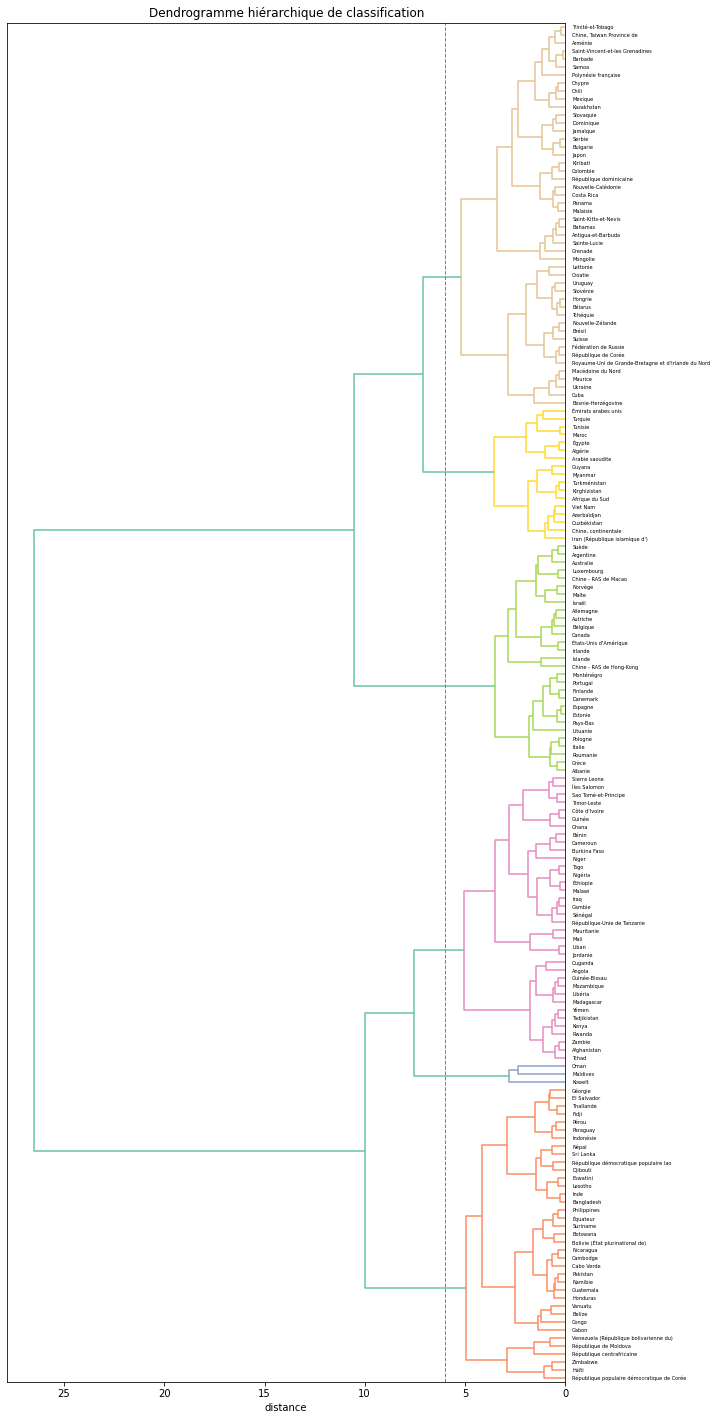

In [16]:
# Préparation des données pour le clustering
X = df.values
names = df.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')


# Affichage du dendrogramme
plt.figure(figsize=(10,25))
sns.set_palette('Set2')
dendrogram(Z,
        labels = names,
        orientation = "left", color_threshold=6)
plt.axvline(x=6, c='grey', lw=1, linestyle='dashed')

plt.title('Dendrogramme hiérarchique de classification')
plt.xlabel('distance')

plt.savefig('/Users/anissa/P5_01_dendrogramme.jpg', dpi=1200)

plt.show()

In [17]:
cluster = fcluster(Z, t=5, criterion='maxclust')
data_cluster = pd.DataFrame({'pays' : df.index.tolist(),
                             'cluster' : cluster})
data_cluster = data_cluster.sort_values(['cluster', 'pays'])
data_cluster.to_csv('/Users/anissa/P5_03_listepays.csv')

### 3. Analyse en Composantes Principales

In [18]:
# On crée les différents composants nécessaires à l'ACP
n_comp = 4

X = df.values
names = df.index
features = df.columns

In [19]:
# On prépare les données en faisant une normalisation (centrage-réduction)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [20]:
# On applique l'ACP sur nos données transformées
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=4)

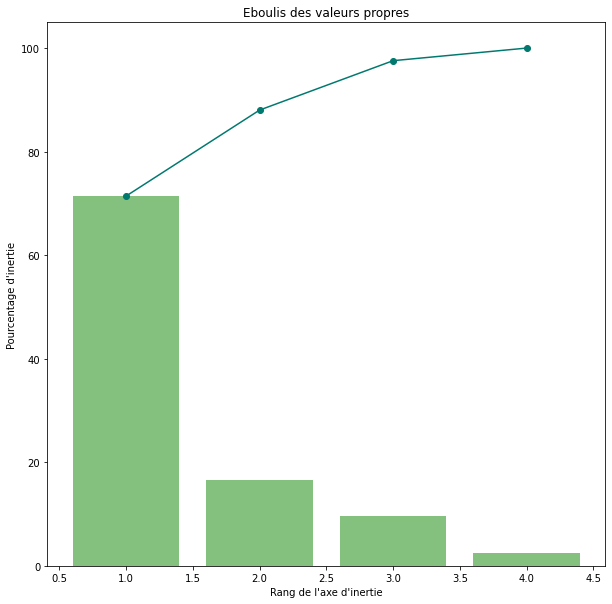

In [21]:
# On affiche l'éboulis des valeurs propres
# On pourra voir le pourcentage d'inertie pour chaque composante

fig, ax = plt.subplots(figsize=(10,10))
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='#85C17E')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='#01796F')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")

plt.savefig('/Users/anissa/P5_Eboulis.jpg', dpi=1200)

plt.show(block=False)

Le critère du Kaiser nous conduit à retenir les deux premiers axes. En effet le premier axe retient 71.4% de l’inertie totale quant à l’axe 2 retient tout de même 16.6% de l’inertie, ce qui n’est pas négligeable. Et qui conduit à un taux d’inertie expliquée de 88%, ce qui est un très bon résultat.

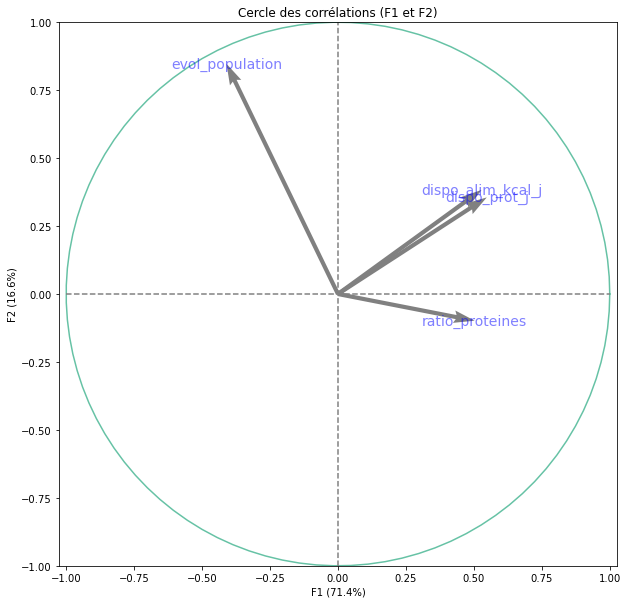

In [22]:
pcs = pca.components_

# On affiche le cercle des corrélations du premier plan avec les composantes F1 et F2
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

F1 correspond au régime alimentaire  
F2 correspond à la croissance de la population

In [23]:
df = pd.merge(df, data_cluster, on='pays')
illustrative_var = df['cluster']
df = df.set_index('pays')

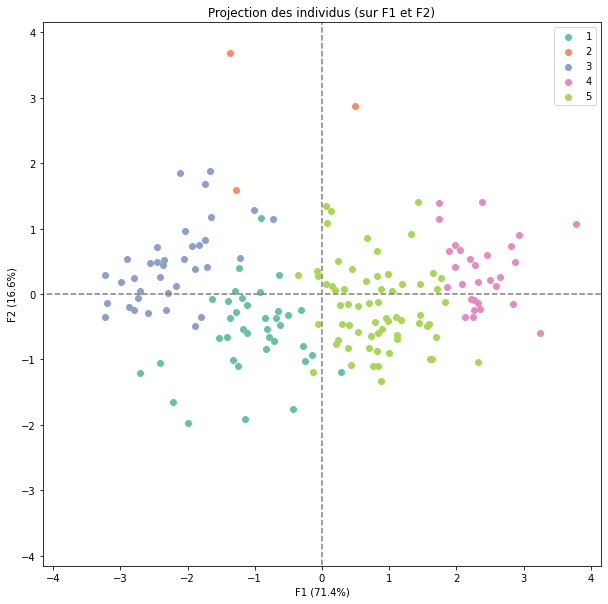

In [24]:
sns.set_palette('Set2')
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=illustrative_var)

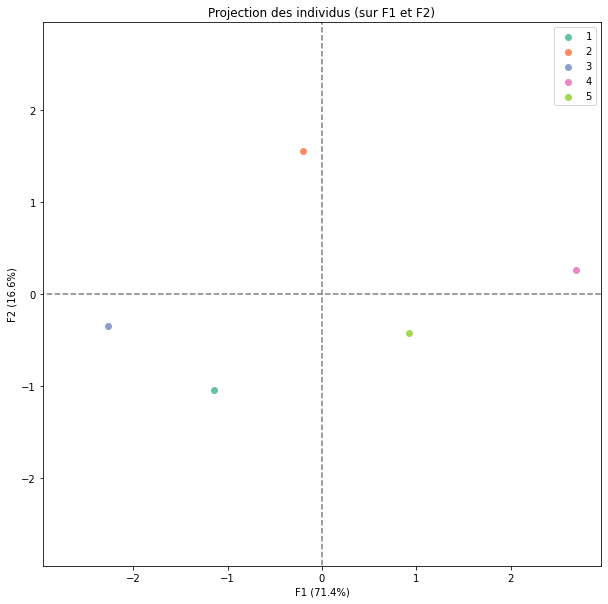

In [25]:
df2 = df.groupby('cluster').mean().reset_index()
df2 = df2.set_index('cluster')

sns.set_palette('Set2')
X = df2.values 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Projection des points dans le premier plan factoriel
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df2.index)

Les clusters 1 & 3 sont corrélés de façon négative à F1 et F2. Nous allons donc les exclure et procéder à une deuxième analyse.

In [26]:
# Position des centroïdes
coor_centroids = pd.DataFrame(X_scaled, columns=df2.columns, index=df2.index)
coor_centroids.to_csv('/Users/anissa/P5_04_coordonneescentroides.csv')

### 4. Visualisation des clusters : _map_

_sources :_   
* https://docs.bokeh.org/en/latest/docs/user_guide/geo.html
* https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

In [27]:
code_pays = pd.read_csv("/Users/anissa/P5/code_pays.csv")

shapefile = '/Users/anissa/P5/ne_110m_admin_0_countries'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']

print(gdf[gdf['country'] == 'Antarctica'])
#Drop row corresponding to 'Antarctica'
gdf = gdf.drop(gdf.index[159])

# Jointure entre code pays et gdf
gdf_fao = gdf.merge(code_pays, left_on=['country_code'],
                    right_on=['Code ISO3'], how='left')

gdf_fao = gdf_fao.drop(columns=["country","Code M49","Code ISO2",
                                "Année de début", "Año de inicio"])

# Jointure entre l'étude de marché et gdf
ba_pays_gdf = gdf_fao.merge(df, left_on=["Pays"], right_on=["pays"], how="left")
ba_pays_gdf = ba_pays_gdf.drop(columns=["Pays","country_code","Code ISO3",
                                        "dispo_alim_kcal_j","dispo_prot_j",
                                        "evol_population","ratio_proteines","Code Pays"])

#Read data to json.
merged_json = json.loads(ba_pays_gdf.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

geosource = GeoJSONDataSource(geojson = json_data)

#Define a color palette.
palette=['#66B397', '#F88E55', '#82A8CB', '#F19BD6', '#9FE855']

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 1, 
                                 high = 5, nan_color="#F9F8F7")
ticker = FixedTicker(ticks=[1,2,3,4,5])

#Define custom tick labels for color bar.
tick_labels = {'1':'Cluster 1','2':'Cluster 2','3':'Cluster 3',
               '4':'Cluster 4','5':'Cluster 5'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=5,
                     width = 880, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', 
                     ticker=ticker, major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = "Répartition en clusters des pays analysés", 
           plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'cluster', 
                                                      'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

        country country_code  \
159  Antarctica          ATA   

                                              geometry  
159  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...  


Loading BokehJS ...

### 5. Test d'adéquation

Nous allons vérifier l'adéquation de nos variables à une loi normale. Notre echantillon étant supérieur à n>50, nous allons effectuer à un test de Kolmogorov-Smirnov.  
On pose les hypothèses suivantes :

$$\begin{cases}
    H_0     \quad \text{F} = \text{F}_0\\
    H_1     \quad \text{F} \neq\ \text{F}_0
  \end{cases}$$

H$_0$ est donc l'hypothèse d'égalité que l'on cherche à ne pas rejeter. Si H$_0$ est vraie alors la variable dans notre échantillon de pays suit la loi normale. Le risque n'étant pas précisé, on choisira α=5%.

#### 5.1. Test de Kolmogorov-Smirnov : _disponibilité alimentaire en calories_

<Figure size 720x720 with 0 Axes>

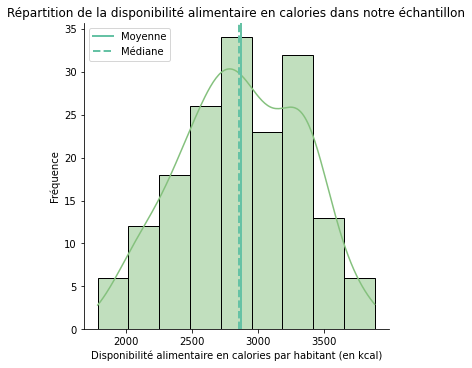

In [28]:
plt.figure(figsize = (10,10))

sns.displot(df["dispo_alim_kcal_j"],
                     kde=True,
                  color='#85C17E')

plt.axvline(x=df["dispo_alim_kcal_j"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df["dispo_alim_kcal_j"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('Disponibilité alimentaire en calories par habitant (en kcal)')
plt.ylabel('Fréquence')
plt.title('Répartition de la disponibilité alimentaire en calories dans notre échantillon')
plt.legend()


plt.show()

In [29]:
ks_2samp(df["dispo_alim_kcal_j"],list(np.random.normal(np.mean(df["dispo_alim_kcal_j"]), 
                                                            np.std(df["dispo_alim_kcal_j"]), 1000))) # suit une loi normale

KstestResult(statistic=0.08288235294117648, pvalue=0.2550824834251273)

La pvalue étant supérieure à α=0.05, on ne rejette pas l'hypothèse H$_0$. La variable _"disponibilité alimentaire en calories"_ **suit donc une loi normale**.

#### 5.2. Test de Kolmorogov-Smirnov : _disponibilité alimentaire en protéines_

<Figure size 720x720 with 0 Axes>

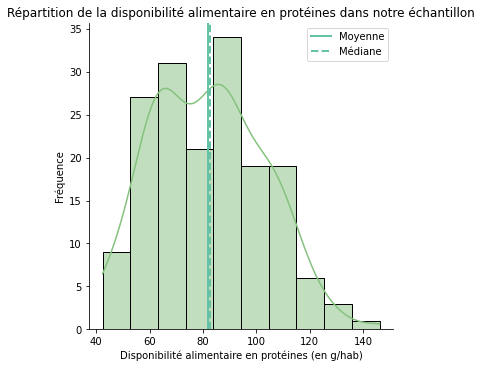

In [30]:
plt.figure(figsize = (10,10))

sns.displot(df["dispo_prot_j"],
                  kde=True,
                  color='#85C17E')
plt.axvline(x=df["dispo_prot_j"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df["dispo_prot_j"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('Disponibilité alimentaire en protéines (en g/hab)')
plt.ylabel('Fréquence')
plt.title('Répartition de la disponibilité alimentaire en protéines dans notre échantillon')
plt.legend()


plt.show()

In [31]:
ks_2samp(df["dispo_prot_j"],list(np.random.normal(np.mean(df["dispo_prot_j"]), 
                                                       np.std(df["dispo_prot_j"]), 1000))) # suit une loi normale

KstestResult(statistic=0.08952941176470589, pvalue=0.18208715883864446)

La pvalue étant supérieure à α=0.05, on ne rejette pas l'hypothèse H$_0$. La variable _"disponibilité alimentaire en protéines"_ **suit donc une loi normale**.

#### 5.3. Test de Kolmorogov-Smirnov : _croissance de la population_

<Figure size 720x720 with 0 Axes>

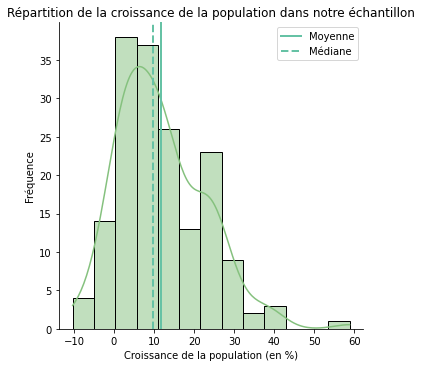

In [32]:
plt.figure(figsize = (10,10))

sns.displot(df["evol_population"],
                  kde=True,
                  color='#85C17E')
plt.axvline(x=df["evol_population"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df["evol_population"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('Croissance de la population (en %)')
plt.ylabel('Fréquence')
plt.title('Répartition de la croissance de la population dans notre échantillon')
plt.legend()

plt.show()

In [33]:
ks_2samp(df["evol_population"],list(np.random.normal(np.mean(df["evol_population"]), 
                                                          np.std(df["evol_population"]), 1000))) # suit une loi normale

KstestResult(statistic=0.09658823529411764, pvalue=0.12362826408167693)

La pvalue étant supérieure à α=0.05, on ne rejette pas l'hypothèse H$_0$. La variable _"croissance de la population"_ **suit donc une loi normale**.

#### 5.4. Test de Kolmogorov-Smirnov : _proportion de protéines animales_

<Figure size 720x720 with 0 Axes>

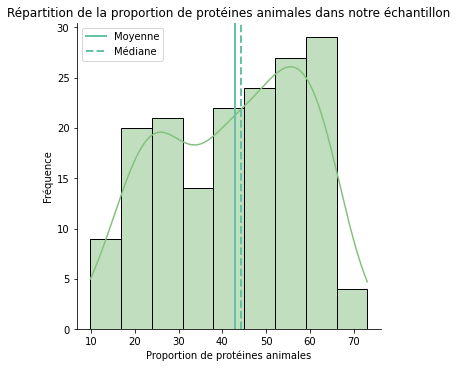

In [34]:
plt.figure(figsize = (10,10))

sns.displot(df['ratio_proteines'],
                  kde=True,
                  color='#85C17E')
plt.axvline(x=df['ratio_proteines'].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df['ratio_proteines'].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('Proportion de protéines animales')
plt.ylabel('Fréquence')
plt.title('Répartition de la proportion de protéines animales dans notre échantillon')
plt.legend()

plt.show()

In [35]:
ks_2samp(df["ratio_proteines"],list(np.random.normal(np.mean(df["ratio_proteines"]), 
                                                          np.std(df["ratio_proteines"]), 1000))) # suit une loi normale

KstestResult(statistic=0.07947058823529411, pvalue=0.3000452861588683)

La pvalue étant supérieure à α=0.05, on ne rejette pas l'hypothèse H$_0$. La variable _"proportion de protéines animales"_ **suit donc une loi normale**.

In [36]:
df['cluster'].value_counts() # répartition des pays dans les 5 clusters

5    65
1    37
3    36
4    29
2     3
Name: cluster, dtype: int64

### 6. Test de comparaison

Nous allons vérifier la significativité de nos données en comparant les variances et les moyennes de 2 clusters. Notre choix se porte sur les clusters 1 et 5.  
Comme vu précédemment, les clusters 1 et 3 sont ceux que nous allons exclure de notre prochaine analyse. Nous faisons ici le choix de comparer un de ces clusters avec un cluster pertinent. Les clusters à exclure étant de gros échantillons (n>30), et afin de ne pas fausser les tests, nous allons le comparer au cluster 5, qui est également de grande taille.

Pour comparer les moyennes, il faut d'abord comparer les variances. Cela nous permettra de choisir le bon test à réaliser. Les résultats trouvés lors des tests d'adéquation ont un impact sur le choix de tests de comparaison des variances et des moyennes :
- Lorsqu'une variable est continue (suit une loi normale), il faudra réaliser un test dit "paramétrique". Le **test de Bartlett** est ici adéquat pour comparer les variances, celui de Student pour les moyennes (car n>30).
- Si ne n'est pas le cas, il faudra réaliser un test dit "non paramétrique". Les tests choisis ici seront le test de **Fligner-Killeen** (variances) et le **test de Mann-Whitney** (moyennes).

Nous posons les hypothèses suivantes pour la comparaison des variances :
$$\begin{cases}
    H_0      \quad \sigma^2_1 = \sigma^2_2\\
    H_1      \quad \sigma^2_1 \neq\ \sigma^2_2
  \end{cases}$$
  
L'hypothèse nulle ($H_0$) correspond à des variances égales. Sous l’alternative alternative ($H_1$), les variances des deux clusters sont différentes. Le risque n’étant pas précisé, on prendra α = 5%.

À noter : si nous rejetons $H_0$, nous devrons effectuer le **test de Welch** pour comparer nos moyennes.

Nous posons les hypothèses suivantes pour la comparaison des moyennes :

$$\begin{cases}
    H_0     \quad \mu^2_1 = \mu^2_2\\
    H_1     \quad \mu^2_1 \neq\ \mu^2_2
  \end{cases}$$
  
Sous l'hypothèse nulle ($H_0$), les moyennes des clusters sont égales. L'hypothèse alternative ($H_1$) correspond, elle, à des moyennes inégales.

#### 6.1. Comparaison entre les clusters 1 et 5 : _disponibilité alimentaire en calories_

##### 6.1.1. Comparaison des variances : _test paramétrique_

In [37]:
# Test de Bartlett
clust1 = df[df["cluster"]==1]["dispo_alim_kcal_j"]
clust5 = df[df["cluster"]==5]["dispo_alim_kcal_j"]
st.stats.bartlett(clust1,clust5) # égalité des variances vérifiée

BartlettResult(statistic=0.02232847672362826, pvalue=0.8812165802062691)

Notre pvalue est supérieure à α = 0.05, nous ne rejetons pas l'hypothèse $H_0$. Les variances de la _disponibilité alimentaire en calories_ de nos 2 clusters sont, par conséquent, **égales**.

##### 6.1.2. Comparaison des moyennes : _test paramétrique_

In [38]:
# Test de Student
stats.ttest_ind(clust1,clust5) # égalité des moyennes non vérifiée

Ttest_indResult(statistic=-9.510705639031935, pvalue=1.1708390732760686e-15)

Notre pvalue est inférieure à α = 0.05, nous ne rejetons pas l'hypothèse $H_0$. Les moyennes de la _disponibilité alimentaire en calories_ de nos 2 clusters sont, par conséquent, **différentes**.

#### 6.2. Comparaison entre les clusters 1 et 5 : _disponibilité alimentaire en protéines_

##### 6.2.1. Comparaison des variances : _test paramétrique_

In [39]:
# Test de Bartlett
clust1 = df[df["cluster"]==1]["dispo_prot_j"]
clust5 = df[df["cluster"]==5]["dispo_prot_j"]
st.stats.bartlett(clust1,clust5) # égalité des variances vérifiée

BartlettResult(statistic=0.24671121157683062, pvalue=0.6194003941249446)

Notre pvalue est supérieure à α = 0.05, nous ne rejetons pas l'hypothèse $H_0$. Les variances de la _disponibilité alimentaire en protéines_ de nos 2 clusters sont, par conséquent, **égales**.

##### 6.2.2. Comparaison des moyennes : _test paramétrique_

In [40]:
# Test de Student
stats.ttest_ind(clust1,clust5) # égalité des moyennes non vérifiée

Ttest_indResult(statistic=-12.970505069923252, pvalue=3.7494461400618504e-23)

Notre pvalue est inférieure à α = 0.05, nous ne rejetons pas l'hypothèse $H_0$. Les moyennes de la _disponibilité alimentaire en protéines_ de nos 2 clusters sont, par conséquent, **différentes**.

#### 6.3. Comparaison entre les clusters 1 et 5 : _croissance de la population_

##### 6.3.1. Comparaison des variances : _test paramétrique_

In [41]:
# Test de Bartlett
clust1 = df[df["cluster"]==1]["evol_population"]
clust5 = df[df["cluster"]==5]["evol_population"]
st.stats.bartlett(clust1,clust5) # égalité des variances vérifiée

BartlettResult(statistic=0.11094624828076288, pvalue=0.739069406748961)

Au seuil α = 0.05, on ne rejette pas l’hypothèse $H_0$. Les variances de la _croissance de la population_ de nos 2 clusters sont donc **égales**.

##### 6.3.2. Comparaison des moyennes : _test paramétrique_

In [42]:
# Test de Student
stats.ttest_ind(clust1,clust5) # égalité des moyennes non vérifiée

Ttest_indResult(statistic=3.2898798589764007, pvalue=0.0013848367977616783)

Comme pvalue < α = 0.05, on rejette $H_0$. Les moyennes de nos 2 clusters pour la variable _croissance de la population_ sont donc **inégales**.

#### 6.4. Comparaison entre les clusters 1 et 5 : _proportion de protéines animales_

##### 6.4.1. Comparaison des variances : _test paramétrique_

In [43]:
# Test de Bartlett
clust1 = df[df["cluster"]==1]["ratio_proteines"]
clust5 = df[df["cluster"]==5]["ratio_proteines"]
st.stats.bartlett(clust1,clust5) # égalité des variances vérifiée

BartlettResult(statistic=0.5236024085015868, pvalue=0.4693090293953903)

Comme pvalue > α = 0.05, on ne rejette pas $H_0$. Les variances de nos 2 clusters pour la variable _proportion de protéines d'origine animale_ sont donc **égales**.

In [44]:
# Test de Student
stats.ttest_ind(clust1,clust5) # égalité des moyennes non vérifiée

Ttest_indResult(statistic=-7.173705540549031, pvalue=1.294647355678304e-10)

Au seuil α = 0.05, on rejette l’hypothèse $H_0$. Les moyennes de la _proportion de protéines animales_ de nos 2 clusters sont donc **différentes**.

-----

## Analyse II

On exclut les clusters 1 et 3.

In [45]:
df = df.loc[(df["cluster"]!=1) & (df["cluster"]!=3)]
df.head()

,dispo_alim_kcal_j,dispo_prot_j,evol_population,ratio_proteines,cluster
pays,,,,,
Arménie,2997.0,94.35,2.586644,48.055114,5
Albanie,3360.0,115.74,-2.214467,53.352341,4
Algérie,3322.0,91.83,17.374639,26.930197,5
Antigua-et-Barbuda,2445.0,80.19,9.381106,64.521761,5
Argentine,3307.0,106.77,8.473736,64.671724,4


### 1. Nouvelles variables : _PIB/habitant_, _importation de viande de volailles_ et _stabilité politique_

_souces :_
* http://www.fao.org/faostat/fr/#data/FS
* http://www.fao.org/faostat/fr/#data/FBS

In [46]:
# PIB/habitant et stabilité politique

secu_alim = securite_alimentaire.drop(columns=["Unité", "Code Produit"])
secu_alimen = pd.pivot_table(secu_alim, index= ["Code zone", "Zone",
                                                         "Année"], 
                                                            columns="Produit", values="Valeur", 
                                                                           aggfunc="sum")
secu_alime = secu_alimen.reset_index()
secu_alime = secu_alime.rename(columns={"Zone":"pays"})

data_fao = pd.merge(df, secu_alime, on='pays')
data_fao.reset_index().head()

,index,pays,dispo_alim_kcal_j,dispo_prot_j,evol_population,ratio_proteines,cluster,Code zone,Année,"PIB par habitant, ($ PPA internationaux constants de 2011)",Stabilité politique et absence de violence/terrorisme (indice)
0,0,Arménie,2997.0,94.35,2.586644,48.055114,5,1,2018,12715.0,-0.42
1,1,Albanie,3360.0,115.74,-2.214467,53.352341,4,3,2018,13601.3,0.38
2,2,Algérie,3322.0,91.83,17.374639,26.930197,5,4,2018,11479.5,-0.79
3,3,Antigua-et-Barbuda,2445.0,80.19,9.381106,64.521761,5,8,2018,21115.8,0.73
4,4,Argentine,3307.0,106.77,8.473736,64.671724,4,9,2018,22745.9,0.02


In [47]:
# Importations de viandes de volailles

import_volailles = pd.pivot_table(import_volailles, index= ["Code zone", "Zone",
                                                         "Année"], 
                                                            columns="Élément", values="Valeur", 
                                                                           aggfunc="sum")
import_volailles = import_volailles.reset_index()

importations = import_volailles.rename(columns={"Zone":"pays"})
data_fao = pd.merge(data_fao, importations, on="pays")

# On renomme les colonnes pour plus de lisibilité
data_final = data_fao.rename(columns=
                   {"Zone":"pays", 
                    "PIB par habitant, ($ PPA internationaux constants de 2011)":"PIB/habitant",
                   "Stabilité politique et absence de violence/terrorisme (indice)":"stabilite_politique",
                   "Importations - Quantité":"importations"})

# On supprime les colonnes dont on a plus besoin
del data_final["Code zone_x"]
del data_final["Code zone_y"]

del data_final["Année_x"]
del data_final["Année_y"]



data_finalite = data_final.reset_index()

df4 = data_finalite.set_index('pays')

nulles = df4[df4.isnull().any(axis=1)]
df5 = df4.dropna(axis = 0, how = 'any')

df5.head() #n=92

,index,dispo_alim_kcal_j,dispo_prot_j,evol_population,ratio_proteines,cluster,PIB/habitant,stabilite_politique,importations
pays,,,,,,,,,
Arménie,0,2997.0,94.35,2.586644,48.055114,5,12715.0,-0.42,33
Albanie,1,3360.0,115.74,-2.214467,53.352341,4,13601.3,0.38,12
Algérie,2,3322.0,91.83,17.374639,26.930197,5,11479.5,-0.79,0
Antigua-et-Barbuda,3,2445.0,80.19,9.381106,64.521761,5,21115.8,0.73,7
Argentine,4,3307.0,106.77,8.473736,64.671724,4,22745.9,0.02,13


### 2. Dendrogramme

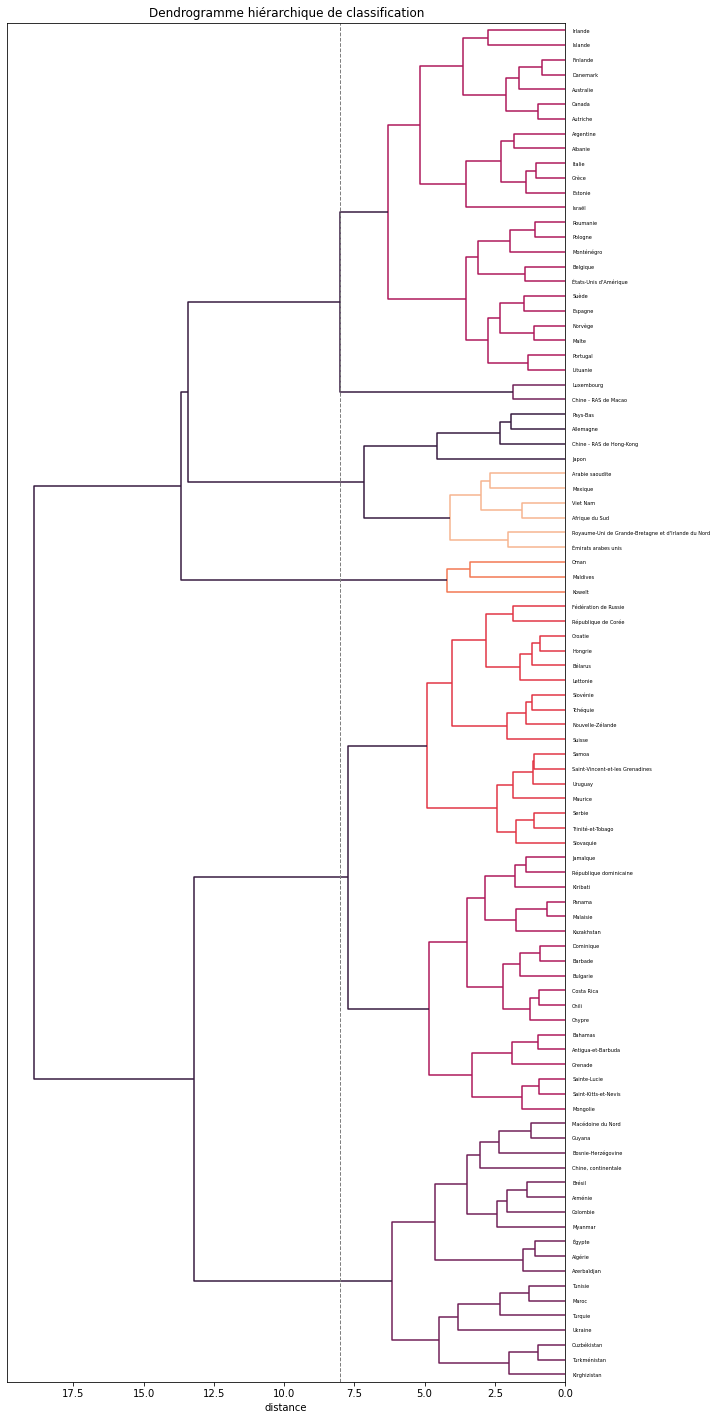

In [48]:
# préparation des données pour le clustering
X = df5.values
names = df5.index

del df5["index"]
del df5["cluster"]

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plt.figure(figsize=(10,25))
sns.set_palette("rocket")

dendrogram(Z,
        labels = names,
        orientation = "left", color_threshold=7)
plt.axvline(x=8, c='grey', lw=1, linestyle='dashed')

plt.title('Dendrogramme hiérarchique de classification')
plt.xlabel('distance')

plt.savefig('/Users/anissa/P5_01_dendrogramme_2.jpg', dpi=1200)

plt.show()

In [49]:
cluster = fcluster(Z, t=5, criterion='maxclust')
data_cluster = pd.DataFrame({'pays' : df5.index.tolist(),
                             'cluster' : cluster})
data_cluster = data_cluster.sort_values(['cluster', 'pays'])
data_cluster.to_csv('/Users/anissa/P5_03_listepays2.csv')

### 3. Analyse en Composantes Principales

In [50]:
# On crée les différents composants nécessaires à l'ACP
n_comp = 4

X = df5.values
names = df5.index
features = df5.columns

In [51]:
# On prépare les données en faisant une normalisation (centrage-réduction)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [52]:
# On applique l'ACP sur nos données transformées
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=4)

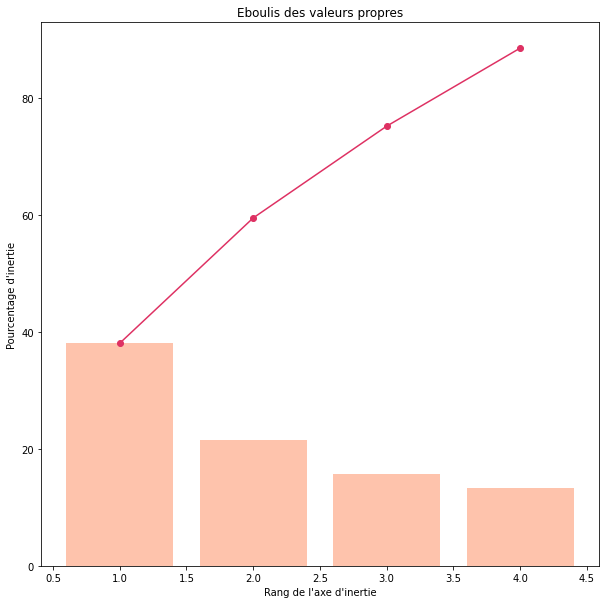

In [53]:
# On affiche l'éboulis des valeurs propres
# On pourra voir le pourcentage d'inertie pour chaque composante

fig, ax = plt.subplots(figsize=(10,10))
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='#FEC3AC')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='#DE3163')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Le critère du Kaiser nous conduit à retenir les deux premiers axes. En effet le premier axe retient 38.0% de l’inertie totale quant à l’axe 2 retient tout de même 21.4% de l’inertie, ce qui n’est pas négligeable. Et qui conduit à un taux d’inertie expliquée de 59.4%, ce qui est un bon résultat.

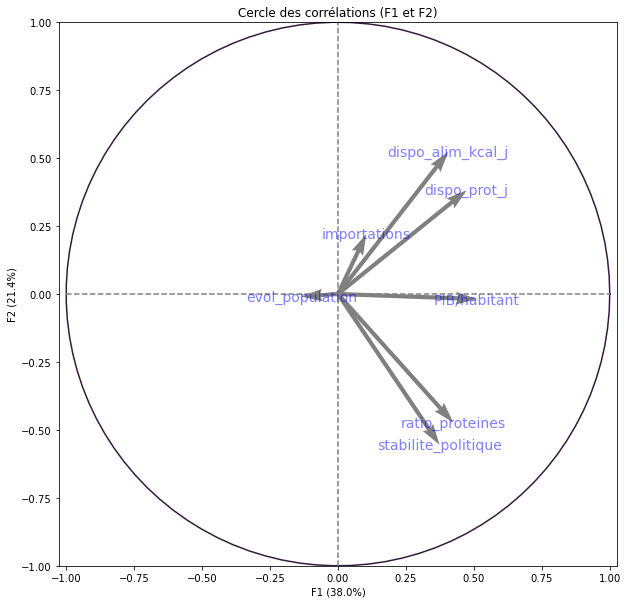

In [54]:
pcs = pca.components_

# On affiche le cercle des corrélations du premier plan avec les composantes F1 et F2
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

F1 correspond aux informations concernant la population (croissance et PIB)  
F2 correspond aux importations et disponibilités 

In [55]:
etude_marche = pd.merge(df5, data_cluster, on='pays')
illustrative_var = etude_marche['cluster']
df_etude = etude_marche.set_index('pays')

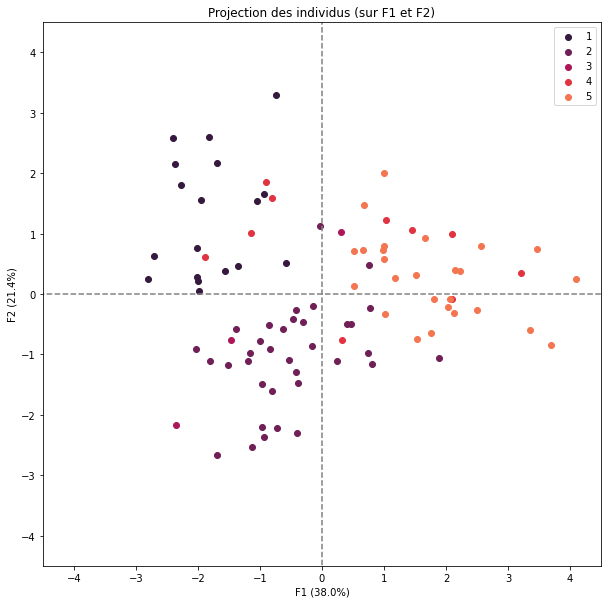

In [56]:
sns.set_palette('rocket')
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=illustrative_var)

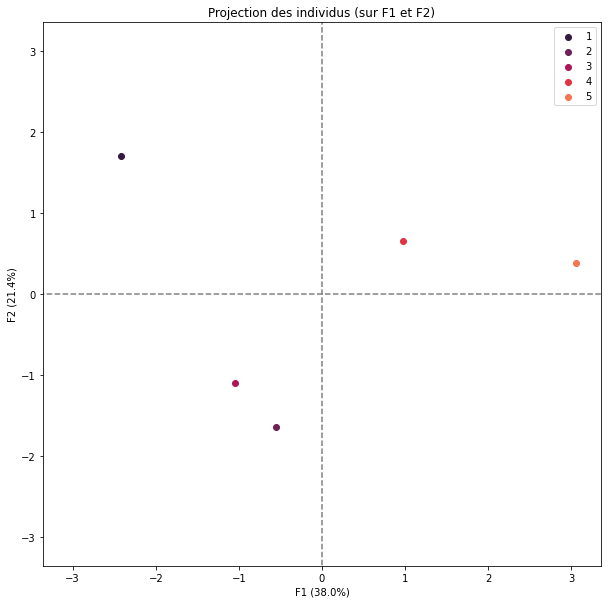

In [57]:
df6 = etude_marche.groupby('cluster').mean().reset_index()
df7 = df6.set_index('cluster')
sns.set_palette('rocket')
X = df7.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Projection des points dans le premier plan factoriel
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df7.index)

Les clusters 4 & 5 sont corrélés de façon positive aux variables correspondant aux disponibilités alimentaires, importations et PIB/habitants. Ces variables sont les plus intéressantes dans cette deuxième analyse. Nous allons donc procéder à une troisième analyse en restreignant à ces 2 clusters.

In [58]:
# Position des centroïdes
coor_centroids = pd.DataFrame(X_scaled, columns=df7.columns, index=df7.index)
coor_centroids.to_csv('/Users/anissa/P5_04_coordonneescentroides_2.csv')

### 4. Visualisation des clusters : _map_

_sources :_   
* https://docs.bokeh.org/en/latest/docs/user_guide/geo.html
* https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

In [59]:
code_pays = pd.read_csv("/Users/anissa/P5/code_pays.csv")

shapefile = '/Users/anissa/P5/ne_110m_admin_0_countries'
#Read shapefile using Geopandas
gdf2 = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf2.columns = ['country', 'country_code', 'geometry']

print(gdf2[gdf2['country'] == 'Antarctica'])
#Drop row corresponding to 'Antarctica'
gdf2 = gdf2.drop(gdf2.index[159])

# Jointure entre code pays et gdf
gdf_fao2 = gdf2.merge(code_pays, left_on=['country_code'],
                      right_on=['Code ISO3'], how='left')

gdf_fao2 = gdf_fao2.drop(columns=["country","Code M49","Code ISO2",
                                  "Année de début", "Año de inicio"])

# Jointure entre l'étude de marché et gdf
ba_pays_gdf2 = gdf_fao2.merge(etude_marche, left_on=["Pays"], 
                              right_on=["pays"], how="left")
ba_pays_gdf2 = ba_pays_gdf2.drop(columns=["Pays","country_code","Code ISO3",
                                          "dispo_alim_kcal_j","dispo_prot_j",
                                          "evol_population","ratio_proteines",
                                          "PIB/habitant","stabilite_politique",
                                          "Code Pays","importations"])

#Read data to json.
merged_json2 = json.loads(ba_pays_gdf2.to_json())
#Convert to String like object.
json_data2 = json.dumps(merged_json2)

geosource2 = GeoJSONDataSource(geojson = json_data2)

#Define a color palette.
palette=['#2A1D2F', '#461F55', '#902F5B', '#DD3D59', '#F58A3E']

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 1, high = 5, 
                                 nan_color="#F9F8F7")
ticker = FixedTicker(ticks=[1,2,3,4,5])

#Define custom tick labels for color bar.
tick_labels = {'1':'Cluster 1','2':'Cluster 2','3':'Cluster 3',
               '4':'Cluster 4','5':'Cluster 5'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=5,
                     width = 880, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', 
                     ticker=ticker, major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = "Répartition en clusters des pays analysés", 
           plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource2,fill_color = {'field' :'cluster', 
                                                       'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

        country country_code  \
159  Antarctica          ATA   

                                              geometry  
159  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...  


Loading BokehJS ...

### 5. Test d'adéquation

Nous allons vérifier l'adéquation de nos variables à une loi normale. Notre echantillon étant supérieur à n>50, nous allons effectuer à un test de **Kolmogorov-Smirnov**.  
On pose les hypothèses suivantes :

$$\begin{cases}
    H_0     \quad \text{F} = \text{F}_0\\
    H_1     \quad \text{F} \neq\ \text{F}_0
  \end{cases}$$

H$_0$ est donc l'hypothèse d'égalité que l'on cherche à ne pas rejeter. Si H$_0$ est vraie alors la variable dans notre échantillon de pays suit la loi normale. Le risque n'étant pas précisé, on choisira α=5%.

#### 5.1. Test de Kolmorogov-Smirnov : _PIB/habitant_

<Figure size 720x720 with 0 Axes>

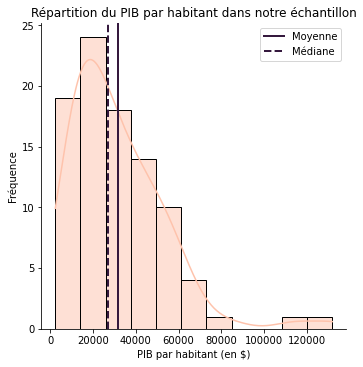

In [60]:
plt.figure(figsize = (10,10))

sns.displot(etude_marche["PIB/habitant"],
                  kde=True,
                  color='#FEC3AC')
plt.axvline(x=etude_marche["PIB/habitant"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=etude_marche["PIB/habitant"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('PIB par habitant (en $)')
plt.ylabel('Fréquence')
plt.title('Répartition du PIB par habitant dans notre échantillon')
plt.legend()


plt.show()

In [61]:
ks_2samp(etude_marche["PIB/habitant"],list(np.random.normal(np.mean(etude_marche["PIB/habitant"]), 
                                                            np.std(etude_marche["PIB/habitant"]), 1000))) # suit une loi normale

KstestResult(statistic=0.11482608695652174, pvalue=0.19954946658151207)

La pvalue étant supérieure à α=0.05, on ne rejette pas l'hypothèse H$_0$. La _variable "PIB/habitant"_ **suit donc une loi normale**.

#### 5.2. Test de Kolmorogov : _stabilité politique_

<Figure size 720x720 with 0 Axes>

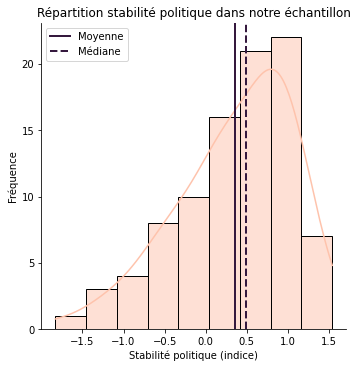

In [62]:
plt.figure(figsize = (10,10))

sns.displot(etude_marche["stabilite_politique"],
                  kde=True,
                  color='#FEC3AC')
plt.axvline(x=etude_marche["stabilite_politique"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=etude_marche["stabilite_politique"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('Stabilité politique (indice)')
plt.ylabel('Fréquence')
plt.title('Répartition stabilité politique dans notre échantillon')
plt.legend()

plt.show()

In [63]:
ks_2samp(etude_marche["stabilite_politique"],list(np.random.normal(np.mean(etude_marche["stabilite_politique"]), 
                                                                   np.std(etude_marche["stabilite_politique"]), 1000))) # suit une loi normale

KstestResult(statistic=0.07804347826086956, pvalue=0.6527212897863937)

La pvalue étant supérieure à α=0.05, on ne rejette pas l'hypothèse H$_0$. La variable _"stabilité politique"_ **suit donc une loi normale**.

#### 5.3. Test de Kolmogorov-Smirnov : _importations de viande de volailles_

<Figure size 720x720 with 0 Axes>

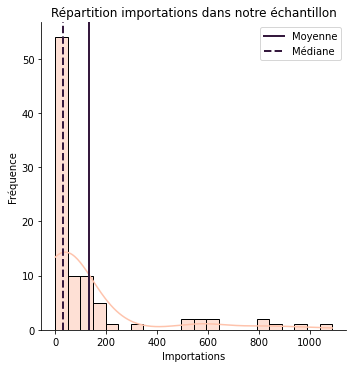

In [64]:
plt.figure(figsize = (10,10))

sns.displot(etude_marche["importations"],
                  kde=True,
                  color='#FEC3AC')
plt.axvline(x=etude_marche["importations"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=etude_marche["importations"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('Importations')
plt.ylabel('Fréquence')
plt.title('Répartition importations dans notre échantillon')
plt.legend()

plt.show()

In [65]:
ks_2samp(etude_marche["importations"],list(np.random.normal(np.mean(etude_marche["importations"]), 
                                                            np.std(etude_marche["importations"]), 1000))) # ne suit pas une loi normale

KstestResult(statistic=0.285, pvalue=1.5156577716224362e-06)

La pvalue étant inférieure à α=0.05, on rejette l'hypothèse H$_0$. La variable _"importations de viandes de volailles"_ **ne suit donc pas une loi normale**.

### 6. Test de comparaison

In [66]:
etude_marche['cluster'].value_counts() # répartition des pays en 5 clusters

2    35
5    26
1    18
4    10
3     3
Name: cluster, dtype: int64

Nous allons vérifier la significativité de nos données en comparant les variances et les moyennes de 2 clusters. Comme vu précedemment, notre choix se porte sur les **clusters 4 et 5**.  
La taille des clusters étant inférieure à 30, nous devrons choisir un test adéquat.

Pour comparer les moyennes, il faut d'abord comparer les variances. Cela nous permettra de choisir le bon test à réaliser. Les résultats trouvés lors des tests d'adéquation ont un impact sur le choix de tests de comparaison des variances et des moyennes :
- Lorsqu'une variable est continue (suit une loi normale), il faudra réaliser un test dit "paramétrique". Le **test de Bartlett** est ici adéquat pour comparer les variances, celui de Wilcoxon pour les moyennes (car n<30).
- Si ne n'est pas le cas, il faudra réaliser un test dit "non paramétrique". Les tests choisis ici seront le **test de Fligner-Killeen** (variances) et le **test de Mann-Whitney** (moyennes).

Nous posons les hypothèses suivantes pour la comparaison des variances :
$$\begin{cases}
    H_0      \quad \sigma^2_1 = \sigma^2_2\\
    H_1      \quad \sigma^2_1 \neq\ \sigma^2_2
  \end{cases}$$
  
L'hypothèse nulle ($H_0$) correspond à des variances égales. Sous l’alternative alternative ($H_1$), les variances des deux clusters sont différentes. Le risque n’étant pas précisé, on prendra α = 5%.



À noter : si nous rejetons $H_0$, nous devrons effectuer le **test de Welch*** pour comparer nos moyennes.

Nous posons les hypothèses suivantes pour la comparaison des moyennes :

$$\begin{cases}
    H_0     \quad \mu^2_1 = \mu^2_2\\
    H_1     \quad \mu^2_1 \neq\ \mu^2_2
  \end{cases}$$
  
Sous l'hypothèse nulle ($H_0$), les moyennes des clusters sont égales. L'hypothèse alternative ($H_1$) correspond, elle, à des moyennes inégales.


#### 6.1. Comparaison entre les clusters 4 et 5 : _stabilité politique_

##### 6.1.1. Comparaison des variances : _test paramétrique_

In [67]:
# Test Barlett
clust4 = etude_marche[etude_marche["cluster"]==4]["stabilite_politique"]
clust5 = etude_marche[etude_marche["cluster"]==5]["stabilite_politique"]
st.stats.bartlett(clust4,clust5) # égalité des variances vérifiée

BartlettResult(statistic=0.1464871579513425, pvalue=0.7019152165709519)

Au seuil α = 0.05, on ne rejette pas l’hypothèse $H_0$. Les _variances de la stabilité politique_ de nos 2 clusters sont donc **égales**.

##### 6.1.2. Comparaison des moyennes : _test paramétrique_

In [68]:
# Test Wilcoxon
st.stats.ttest_ind(clust4,clust5) # égalité des moyennes non vérifiée

Ttest_indResult(statistic=-1.8074925293659563, pvalue=0.07954045865667232)

Notre pvalue est supérieure à α = 0.05, nous ne rejetons pas l'hypothèse $H_0$. Les _moyennes de la stabilité politique en calories_ de nos 2 clusters sont, par conséquent, **égales**.

#### 6.2. Comparaison entre les clusters 4 et 5 : _PIB/habitant_

##### 6.2.1. Comparaison des variances : _test paramétrique_

In [69]:
# Test Barlett
clust4 = etude_marche[etude_marche["cluster"]==4]["PIB/habitant"]
clust5 = etude_marche[etude_marche["cluster"]==5]["PIB/habitant"]
st.stats.bartlett(clust4,clust5) # égalité des variances vérifiée

BartlettResult(statistic=0.6683088377504398, pvalue=0.4136418451734155)

Comme pvalue > α = 0.05, on ne rejette pas $H_0$. Les _variances de nos 2 clusters pour la variable PIB/habitant_ sont donc **égales**.

##### 6.2.2. Comparaison des moyennes : _test paramétrique_

In [70]:
# Test Wilcoxon
st.stats.ttest_ind(clust4,clust5) # égalité des moyennes vérifiée

Ttest_indResult(statistic=-0.8879045803300608, pvalue=0.38083052235862425)

Au seuil α = 0.05, on ne rejette pas l’hypothèse $H_0$. Les _moyennes du PIB/habitant_ de nos 2 clusters sont donc **égales**.

#### 6.3. Comparaison entre les clusters 4 et 5 : _importations_

##### 6.3.1. Comparaison des variances : _test non-paramétrique_

In [71]:
# Test Fligner-Killeen
clust4 = etude_marche[etude_marche["cluster"]==4]["importations"]
clust5 = etude_marche[etude_marche["cluster"]==5]["importations"]
fligner(clust4,clust5) # égalité des variances non vérifiée

FlignerResult(statistic=16.787079300155064, pvalue=4.181706538782726e-05)

Notre pvalue est inférieure à α = 0.05, nous rejetons l'hypothèse $H_0$. Les _variances des importations_ de nos 2 clusters sont, par conséquent, **différentes**.

##### 6.3.2. Comparaison des moyennes : _test non-paramétrique_

In [72]:
# Test Mann-Whitney
st.stats.mannwhitneyu(clust4, clust5) # égalité des moyennes non vérifiée

MannwhitneyuResult(statistic=0.0, pvalue=2.385222955456621e-06)

Comme pvalue < α = 0.05, on rejette $H_0$. Les _moyennes de nos 2 clusters pour la variable importations_ sont donc **différentes**.

-----

## Analyse III

### 1. Nouvelles variables : _quantité de viande de volailles consommée, IPC (Indice Prix à la Consommation)_

_sources :_  
* http://www.fao.org/faostat/fr/#data/FBS
* http://www.fao.org/faostat/fr/#data/CP

On ne garde que les clusters 4 et 5.

In [73]:
analyse_3 = etude_marche.loc[(etude_marche["cluster"]==4) | (etude_marche["cluster"]==5)]
analyse_3.head()

,pays,dispo_alim_kcal_j,dispo_prot_j,evol_population,ratio_proteines,PIB/habitant,stabilite_politique,importations,cluster
1,Albanie,3360.0,115.74,-2.214467,53.352341,13601.3,0.38,12,5
4,Argentine,3307.0,106.77,8.473736,64.671724,22745.9,0.02,13,5
5,Australie,3391.0,105.94,12.383267,66.735888,49576.0,0.98,16,5
6,Autriche,3695.0,109.12,5.724636,60.328079,55687.2,0.92,114,5
12,Canada,3566.0,104.12,8.571616,54.504418,48924.4,0.99,177,5


In [74]:
# Conversion en g/jour
qte_volailles["Valeur"] = (qte_volailles["Valeur"]*1000)/365

qte_volailles.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2018,2018,kg,3.917808,Fc,Donnée calculée
1,FBS,Nouveaux Bilans Alimentaire,202,Afrique du Sud,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2018,2018,kg,105.671233,Fc,Donnée calculée
2,FBS,Nouveaux Bilans Alimentaire,3,Albanie,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2018,2018,kg,25.972603,Fc,Donnée calculée
3,FBS,Nouveaux Bilans Alimentaire,4,Algérie,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2018,2018,kg,19.123288,Fc,Donnée calculée
4,FBS,Nouveaux Bilans Alimentaire,79,Allemagne,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2018,2018,kg,49.726027,Fc,Donnée calculée


In [75]:
# Consommation de viandes de volailles

qte_volailles = pd.pivot_table(qte_volailles, index= ["Code zone", "Zone",
                                                         "Année"], 
                                                            columns="Élément", values="Valeur", aggfunc="sum")



qte_volailles = qte_volailles.reset_index()

qte_volailles = qte_volailles.rename(columns={"Zone":"pays",
                                              "Disponibilité alimentaire en quantité (kg/personne/an)":"consommation_volailles"})

del qte_volailles["Code zone"]
del qte_volailles["Année"]



analyse_3 = pd.merge(analyse_3, qte_volailles, on='pays') #jointure
del analyse_3["cluster"]

In [76]:
# Taux d'inflation

ipc = pd.pivot_table(ipc, index= ["Code zone", "Zone", "Année"], 
                     columns="Mois", values="Valeur", aggfunc="sum")
ipc = ipc.reset_index()

ipc["inflation"] = (ipc.loc[:, "Août":"Septembre"].sum(axis=1))/12

ipc = ipc.rename(columns={"Zone":"pays"})
analyse_3 = pd.merge(analyse_3, ipc, on='pays')
col_list = ["pays","dispo_alim_kcal_j","dispo_prot_j", "evol_population", 
            "ratio_proteines", "PIB/habitant", "stabilite_politique", 
            "importations", "consommation_volailles", "inflation"]
analyse_finale = analyse_3[col_list]

analyse_finale.head() #n=36

,pays,dispo_alim_kcal_j,dispo_prot_j,evol_population,ratio_proteines,PIB/habitant,stabilite_politique,importations,consommation_volailles,inflation
0,Albanie,3360.0,115.74,-2.214467,53.352341,13601.3,0.38,12,25.972603,2.678288
1,Argentine,3307.0,106.77,8.473736,64.671724,22745.9,0.02,13,121.232877,32.162954
2,Australie,3391.0,105.94,12.383267,66.735888,49576.0,0.98,16,133.315068,0.394545
3,Autriche,3695.0,109.12,5.724636,60.328079,55687.2,0.92,114,50.712329,1.522093
4,Canada,3566.0,104.12,8.571616,54.504418,48924.4,0.99,177,110.904110,0.812100


### 2. Dendrogramme

In [77]:
df_analyse = analyse_finale.set_index('pays')
df_analyse.reset_index().head()

,pays,dispo_alim_kcal_j,dispo_prot_j,evol_population,ratio_proteines,PIB/habitant,stabilite_politique,importations,consommation_volailles,inflation
0,Albanie,3360.0,115.74,-2.214467,53.352341,13601.3,0.38,12,25.972603,2.678288
1,Argentine,3307.0,106.77,8.473736,64.671724,22745.9,0.02,13,121.232877,32.162954
2,Australie,3391.0,105.94,12.383267,66.735888,49576.0,0.98,16,133.315068,0.394545
3,Autriche,3695.0,109.12,5.724636,60.328079,55687.2,0.92,114,50.712329,1.522093
4,Canada,3566.0,104.12,8.571616,54.504418,48924.4,0.99,177,110.904110,0.812100


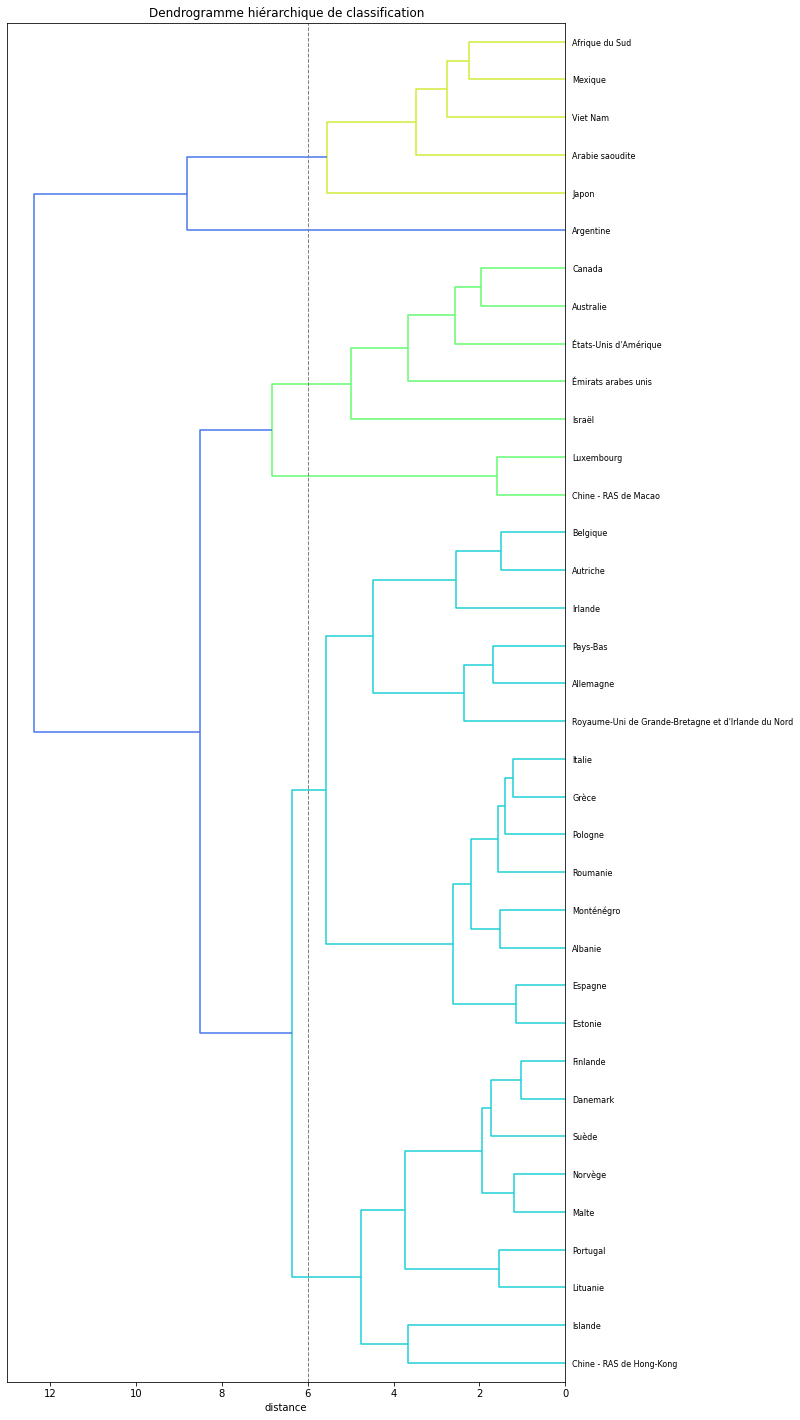

In [78]:
# préparation des données pour le clustering
X = df_analyse.values
names = df_analyse.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')


# Affichage du dendrogramme
plt.figure(figsize=(10,25))
sns.set_palette('turbo')
dendrogram(Z,
        labels = names,
        orientation = "left", color_threshold=7)
plt.axvline(x=6, c='grey', lw=1, linestyle='dashed')

plt.title('Dendrogramme hiérarchique de classification')
plt.xlabel('distance')

plt.savefig('/Users/anissa/P5_01_dendrogramme_3.jpg', dpi=1200)

plt.show()

In [79]:
cluster = fcluster(Z, t=5, criterion='maxclust')
data_cluster2 = pd.DataFrame({'pays' : df_analyse.index.tolist(),
                             'cluster' : cluster})
data_cluster2 = data_cluster2.sort_values(['cluster', 'pays'])
data_cluster2.to_csv('/Users/anissa/P5_03_listepays3.csv')

### 3. Analyse en Composantes Principales

In [80]:
# On crée les différents composants nécessaires à l'ACP
n_comp = 4

X = df_analyse.values
names = df_analyse.index
features = df_analyse.columns

In [81]:
# On prépare les données en faisant une normalisation (centrage-réduction)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [82]:
# On applique l'ACP sur nos données transformées
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=4)

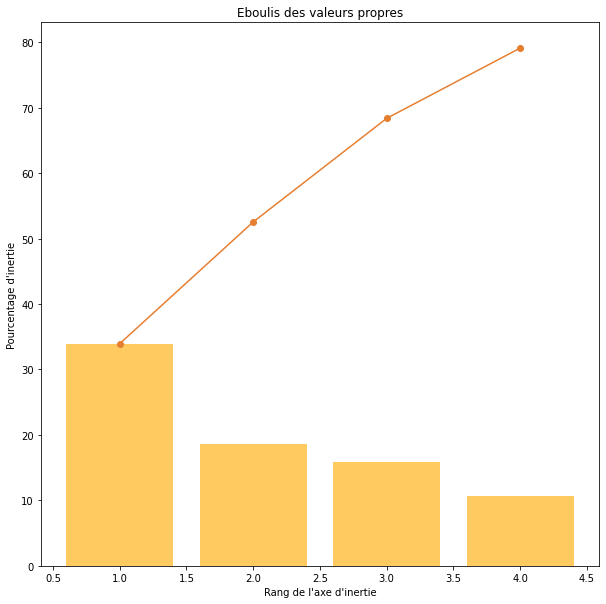

In [83]:
# On affiche l'éboulis des valeurs propres
# On pourra voir le pourcentage d'inertie pour chaque composante

fig, ax = plt.subplots(figsize=(10,10))
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='#FFCB60')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='#E67E30')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Le critère de Kaiser nous conduit à retenir les deux premiers axes. En effet le premier axe retient 33.9% de l’inertie totale quant à l’axe 2 retient tout de même 18.6% de l’inertie, ce qui n’est pas négligeable. Et qui conduit à un taux d’inertie expliquée de 52.8%, ce qui est un bon résultat.

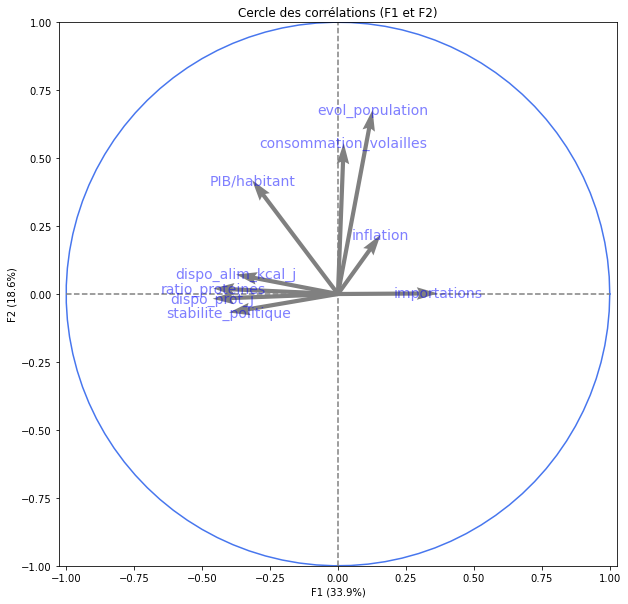

In [84]:
pcs = pca.components_

# On affiche le cercle des corrélations du premier plan avec les composantes F1 et F2
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

F1 correspond au régime alimentaire, aux importations et stabilité politique  
F2 correspond aux informations sur la population (croissance, PIB, inflation et consommation de volailles)


In [85]:
etude_marche2 = pd.merge(df_analyse, data_cluster2, on='pays')
illustrative_var = etude_marche2['cluster']
df_etude = etude_marche.set_index('pays')

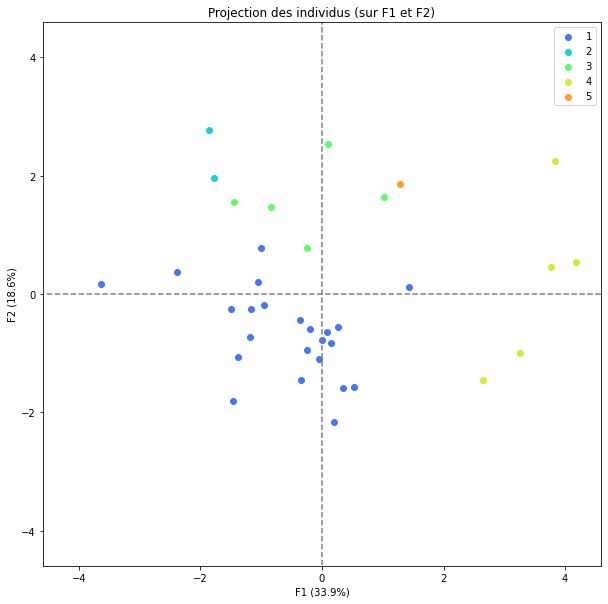

In [86]:
sns.set_palette('turbo')
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=illustrative_var)

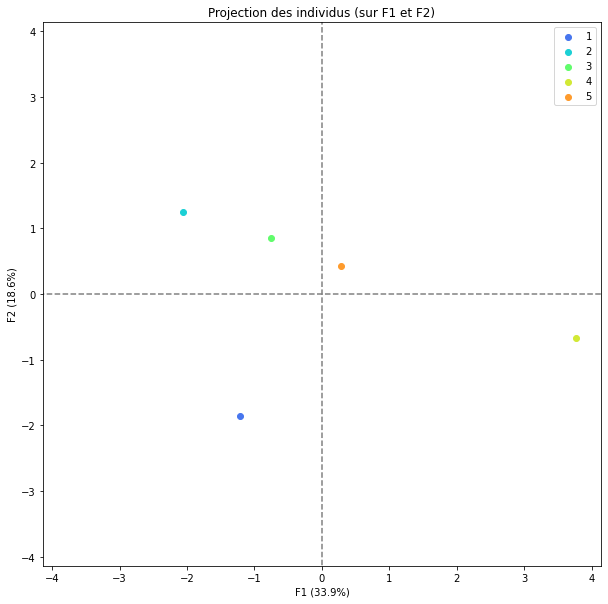

In [87]:
analyse = etude_marche2.groupby('cluster').mean().reset_index()
analyse = analyse.set_index('cluster')
sns.set_palette('turbo')
X = analyse.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Projection des points dans le premier plan factoriel
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=analyse.index)

Les clusters 3 & 4 sont ici les plus intéressants. Les 2 clusters sont corrélés de façon positive aux variables d’importations et de consommation de volailles, ce qui est pertinent pour notre troisième analyse.  
A noter que le cluster 5 est fortement corrélé à la variable "inflation", son taux d'inflation est donc très élevé, ce qui n'est pas intéressant pour l'exportation.

In [88]:
# Position des centroïdes
coor_centroids = pd.DataFrame(X_scaled, columns=analyse.columns, index=analyse.index)
coor_centroids.to_csv('/Users/anissa/P5_04_coordonneescentroides_3.csv')

### 4. Visualisation graphique : _map_

_sources :_  

* https://docs.bokeh.org/en/latest/docs/user_guide/geo.html
* https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

In [89]:
code_pays = pd.read_csv("/Users/anissa/P5/code_pays.csv")

shapefile = '/Users/anissa/P5/ne_110m_admin_0_countries'
#Read shapefile using Geopandas
gdf3 = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf3.columns = ['country', 'country_code', 'geometry']

print(gdf3[gdf3['country'] == 'Antarctica'])
#Drop row corresponding to 'Antarctica'
gdf3 = gdf3.drop(gdf3.index[159])

# Jointure entre code pays et gdf
gdf_fao3 = gdf3.merge(code_pays, left_on=['country_code'],
                      right_on=['Code ISO3'], how='left')

gdf_fao3 = gdf_fao3.drop(columns=["country","Code M49","Code ISO2",
                                  "Année de début", "Año de inicio"])

# Jointure entre l'étude de marché et gdf
ba_pays_gdf3 = gdf_fao3.merge(etude_marche2, left_on=["Pays"], 
                              right_on=["pays"], how="left")
ba_pays_gdf3 = ba_pays_gdf3.drop(columns=["Pays","country_code","Code ISO3",
                                          "dispo_alim_kcal_j",
                                          "dispo_prot_j","evol_population",
                                          "ratio_proteines","PIB/habitant",
                                          "stabilite_politique","Code Pays","importations"])

#Read data to json.
merged_json3 = json.loads(ba_pays_gdf3.to_json())
#Convert to String like object.
json_data3 = json.dumps(merged_json3)

geosource3 = GeoJSONDataSource(geojson = json_data3)

#Define a color palette.
palette=['#375ABC', '#55D4D4', '#6FED40', '#C0DD69', '#FD9944']

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 1, high = 5, 
                                 nan_color="#F9F8F7")
ticker = FixedTicker(ticks=[1,2,3,4,5])

#Define custom tick labels for color bar.
tick_labels = {'1':'Cluster 1','2':'Cluster 2','3':'Cluster 3',
               '4':'Cluster 4','5':'Cluster 5'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=5,
                     width = 880, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', 
                     ticker=ticker, major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = "Répartition en clusters des pays analysés", 
           plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource3,fill_color = {'field' :'cluster', 
                                                       'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

        country country_code  \
159  Antarctica          ATA   

                                              geometry  
159  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...  


Loading BokehJS ...

### 5. Test d'adéquation

Nous allons vérifier l'adéquation de nos variables à une loi normale. Notre echantillon étant inférieur à n>50, nous allons effectuer à un **test de Shapiro-Wilk**.  
On pose les hypothèses suivantes :

$$\begin{cases}
    H_0      \quad \text{W} = \text{W}_0\\
    H_1      \quad \text{W} \neq\ \text{W}_0
  \end{cases}$$

H$_0$ est donc l'hypothèse d'égalité que l'on cherche à ne pas rejeter. Si H$_0$ est vraie alors la variable dans notre échantillon de pays suit la loi normale. Le risque n'étant pas précisé, on choisira _α=5%_.

#### 5.1. Test de Shapiro-Wilk : _inflation (IPC)_

<Figure size 720x720 with 0 Axes>

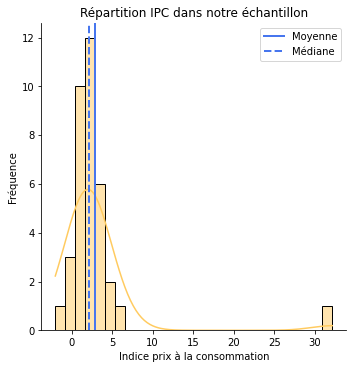

In [90]:
plt.figure(figsize = (10,10))

sns.displot(etude_marche2["inflation"],
                  kde=True,
                  color='#FFCB60')
plt.axvline(x=etude_marche2["inflation"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=etude_marche2["inflation"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('Indice prix à la consommation')
plt.ylabel('Fréquence')
plt.title('Répartition IPC dans notre échantillon')
plt.legend()

plt.show()

In [91]:
test_inflation = etude_marche2["inflation"]
shapiro(test_inflation) # on rejette H0

ShapiroResult(statistic=0.4117646813392639, pvalue=7.251157313481471e-11)

La pvalue étant inférieure à α=0.05, la pvalue est non significative - on rejette l'hypothèse H$_0$. La variable _"inflation"_ **ne suit donc pas une loi normale**.

#### 5.2. Test de Shapiro-Wilk : _consommation de volailles_

<Figure size 720x720 with 0 Axes>

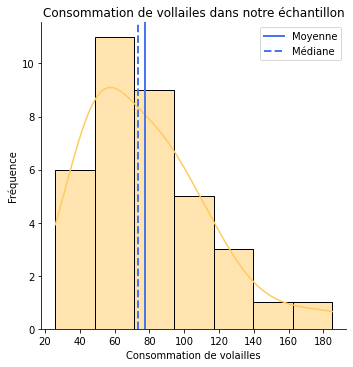

In [92]:
plt.figure(figsize = (10,10))

sns.displot(etude_marche2["consommation_volailles"],
                  kde=True,
                  color='#FFCB60')
plt.axvline(x=etude_marche2["consommation_volailles"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=etude_marche2["consommation_volailles"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('Consommation de volailles')
plt.ylabel('Fréquence')
plt.title('Consommation de vollailes dans notre échantillon')
plt.legend()

plt.show()

In [93]:
test_conso_volailles = etude_marche2["consommation_volailles"]
shapiro(test_conso_volailles) # On rejette H0

ShapiroResult(statistic=0.9247248768806458, pvalue=0.01736881397664547)

La pvalue étant inférieure à α=0.05, la pvalue est non significative - on rejette l'hypothèse H$_0$. La variable _"consommation de volailles"_ **ne suit donc pas une loi normale**.

### 6. Analyse des données des clusters 3 et 4

In [94]:
# Df comportant les données des clusters 3 & 4 (pays potentiels)

pays_potentiels = etude_marche2.loc[(etude_marche2["cluster"]==3) | (etude_marche2["cluster"]==4)]
pays_potentiels.head()

,pays,dispo_alim_kcal_j,dispo_prot_j,evol_population,ratio_proteines,PIB/habitant,stabilite_politique,importations,consommation_volailles,inflation,cluster
2,Australie,3391.0,105.94,12.383267,66.735888,49576.0,0.98,16,133.315068,0.394545,3
4,Canada,3566.0,104.12,8.571616,54.504418,48924.4,0.99,177,110.904110,0.812100,3
13,Israël,3528.0,126.94,14.089398,58.838821,39543.2,-0.93,0,185.041096,0.939132,3
15,Japon,2705.0,87.36,-1.042583,55.631868,41074.1,1.06,1089,51.452055,1.627404,4
19,Mexique,3157.0,91.50,10.603480,48.939891,19992.2,-0.57,983,94.410959,4.829993,4


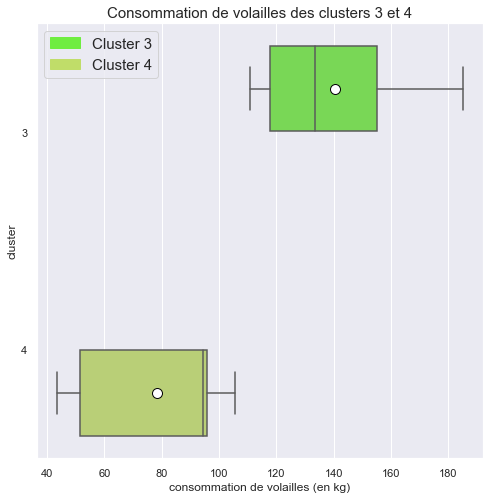

In [95]:
# Consommation de volailles (clusters 3 & 4)

sns.set(rc={'figure.figsize':(8,8)})
my_pal = ["#6FED40", "#C0DD69"]

plt.title("Consommation de volailles des clusters 3 et 4", size=15)

boxplot_prix = sns.boxplot(x="consommation_volailles",y="cluster", 
                           data=pays_potentiels, 
                           hue="cluster", showmeans=True, 
                           meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"}, palette=my_pal, orient="h")
boxplot_prix.set(xlabel="consommation de volailles (en kg)",ylabel="cluster")

cluster3 = mpatches.Patch(color="#6FED40", label="Cluster 3")
cluster4 = mpatches.Patch(color="#C0DD69", label="Cluster 4")


boxplot_prix.legend(handles=[cluster3,cluster4], prop={"size":15})

plt.show()

Text(0.5, 1.0, 'PIB/habitant pour chacun pays des clusters 3 et 4')

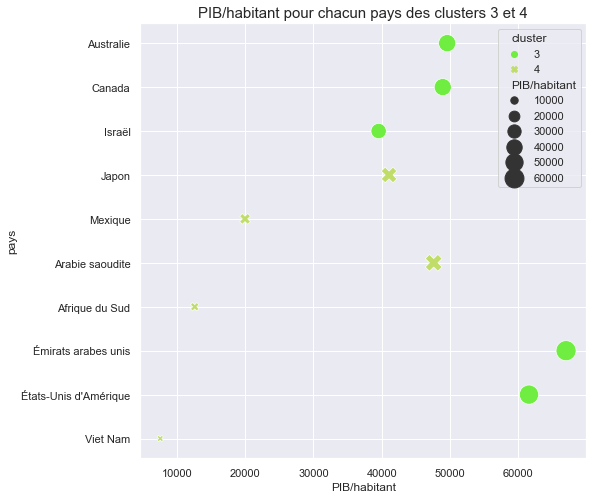

In [96]:
# PIB/habitant (clusters 3 & 4)

sns.scatterplot(data=pays_potentiels, x="PIB/habitant", y="pays",hue="cluster", 
                style="cluster", palette=my_pal, size="PIB/habitant", sizes=(40, 400))
plt.title("PIB/habitant pour chacun pays des clusters 3 et 4", size=15)

Consommation élevée de viande de volailles s'explique pas un PIB/habitant plus élevé : plus accès à un régime alimentaire protéiné.

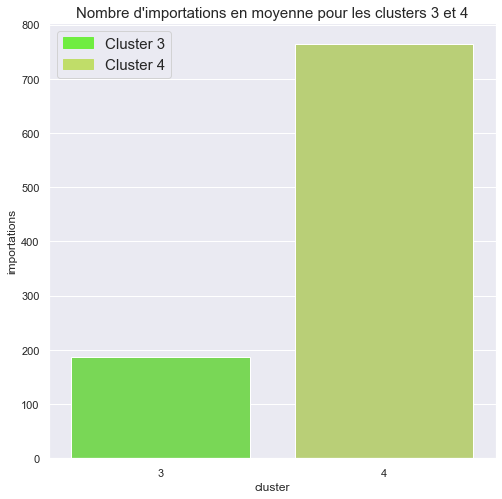

In [97]:
# Importations (clusters 3 & 4)

importations_clusters = pays_potentiels.loc[:,["importations","cluster"]].groupby("cluster").mean()
importations_clusters = importations_clusters.reset_index()

my_pal = ["#6FED40", "#C0DD69"]
importations_clusters = sns.barplot(x="cluster",y="importations",
                              data=importations_clusters, palette=my_pal)
cluster3 = mpatches.Patch(color="#6FED40", label="Cluster 3")
cluster4 = mpatches.Patch(color="#C0DD69", label="Cluster 4")


importations_clusters.legend(handles=[cluster3,cluster4], prop={"size":15})

plt.title("Nombre d'importations en moyenne pour les clusters 3 et 4", size=15)
plt.show()

cluster 4 dépendant des importations de viande de volailles

Text(0.5, 1.0, "Taux d'inflation pour chacun des pays des clusters 3 et 4")

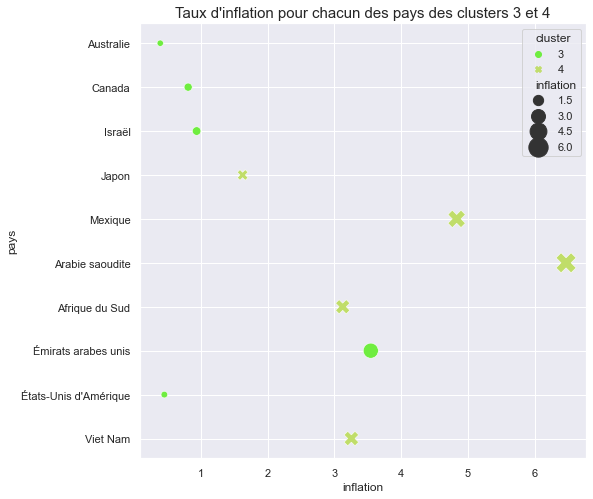

In [98]:
# Taux d'inflation (clusters 3 & 4)

sns.scatterplot(data=pays_potentiels, x="inflation", y="pays",
                hue="cluster", style="cluster", palette=my_pal, 
                size="inflation", sizes=(40, 400))
plt.title("Taux d'inflation pour chacun des pays des clusters 3 et 4", size=15)

In [99]:
etude_marche2[etude_marche2["cluster"]==3]

,pays,dispo_alim_kcal_j,dispo_prot_j,evol_population,ratio_proteines,PIB/habitant,stabilite_politique,importations,consommation_volailles,inflation,cluster
2,Australie,3391.0,105.94,12.383267,66.735888,49576.0,0.98,16,133.315068,0.394545,3
4,Canada,3566.0,104.12,8.571616,54.504418,48924.4,0.99,177,110.904110,0.812100,3
13,Israël,3528.0,126.94,14.089398,58.838821,39543.2,-0.93,0,185.041096,0.939132,3
29,Émirats arabes unis,3314.0,110.26,12.642953,45.764557,66968.3,0.74,609,117.917808,3.544887,3
31,États-Unis d'Amérique,3782.0,113.74,5.852466,64.603482,61544.4,0.48,128,155.178082,0.455970,3


Les importations des pays des clusters 3 sont faibles. Au vue de leurs consommations de volailles, on devine qu'ils en sont producteurs et/ou moins dépendants des importations.

In [100]:
etude_marche2[etude_marche2["cluster"]==4]

,pays,dispo_alim_kcal_j,dispo_prot_j,evol_population,ratio_proteines,PIB/habitant,stabilite_politique,importations,consommation_volailles,inflation,cluster
15,Japon,2705.0,87.36,-1.042583,55.631868,41074.1,1.06,1089,51.452055,1.627404,4
19,Mexique,3157.0,91.50,10.603480,48.939891,19992.2,-0.57,983,94.410959,4.829993,4
25,Arabie saoudite,3307.0,86.94,22.906493,37.658155,47596.7,-0.52,640,95.890411,6.467175,4
26,Afrique du Sud,2899.0,84.37,12.838625,42.704753,12630.8,-0.28,515,105.671233,3.124754,4
32,Viet Nam,3025.0,98.58,8.614884,40.231284,7586.4,0.20,593,43.534247,3.254676,4


### 7. Test de comparaison

Nous allons vérifier la significativité de nos données en comparant les **variances** et les **moyennes** de 2 clusters. Notre choix se porte sur les _clusters 3 et 4_. 
La taille de l'échantillon étant inférieure à 30, nous devons choisir un test adéquat.

Pour comparer les moyennes, il faut d'abord comparer les variances. Cela nous permettra de choisir le bon test à réaliser. Les résultats trouvés lors des tests d'adéquation ont un impact sur le choix de tests de comparaison des variances et des moyennes. Dans cette troisième et dernière analye, nos variables ne sont pas continues. Il faudra réaliser un test dit "non paramétrique". Les tests choisis ici seront le **test de Fligner-Killeen (variances)** et le **test de Mann-Whitney (moyennes)**.

Nous posons les hypothèses suivantes pour la comparaison des variances :
$$\begin{cases}
    H_0      \quad \sigma^2_1 = \sigma^2_2\\
    H_1      \quad \sigma^2_1 \neq\ \sigma^2_2
  \end{cases}$$
  
L'hypothèse nulle ($H_0$) correspond à des variances égales. Sous l’alternative alternative ($H_1$), les variances des deux clusters sont différentes. Le risque n’étant pas précisé, on prendra _α = 5%_.

Nous posons les hypothèses suivantes pour la comparaison des moyennes :

$$\begin{cases}
    H_0     \quad \mu^2_1 = \mu^2_2\\
    H_1     \quad \mu^2_1 \neq\ \mu^2_2
  \end{cases}$$
  
Sous l'hypothèse nulle ($H_0$), les moyennes des clusters sont égales. L'hypothèse alternative ($H_1$) correspond, elle, à des moyennes inégales.


#### 7.1. Comparaison entre les clusters 3 et 4 : _inflation_

##### 7.1.1. Comparaison des variances : _test non-paramétrique_

In [101]:
# Test Fligner-Killeen
cluster_3 = etude_marche2[etude_marche2["cluster"]==3]["inflation"]
cluster_4 = etude_marche2[etude_marche2["cluster"]==4]["inflation"]
fligner(cluster_3,cluster_4) # égalité des variances vérifiée

FlignerResult(statistic=0.5016675497927591, pvalue=0.47876833026181387)

Comme pvalue > α = 0.05, on ne rejette pas $H_0$. Les _variances de nos 2 clusters pour la variable inflation_ sont donc **égales**.

##### 7.1.2. Comparaison des moyennes : _test non-paramétrique_

In [102]:
# Test Mann-Whitney
st.stats.mannwhitneyu(cluster_3, cluster_4) # égalité des moyennes non vérifiée

MannwhitneyuResult(statistic=3.0, pvalue=0.030051402969433157)

Au seuil α = 0.05, on rejette l’hypothèse $H_0$. Les _moyennes de la variable inflation_ de nos 2 clusters sont donc **différentes**.

### 7.2. Comparaison entre les clusters 3 et 4 : _consommation de volailles_

##### 7.2.1. Comparaison des variances : _test non-paramétrique_

In [103]:
# Test Fligner-Killeen
cluster_3 = etude_marche2[etude_marche2["cluster"]==3]["consommation_volailles"]
cluster_4 = etude_marche2[etude_marche2["cluster"]==4]["consommation_volailles"]
fligner(cluster_3,cluster_4) # égalité des variances vérifiée

FlignerResult(statistic=0.19063581432228344, pvalue=0.6623879608536818)

Notre pvalue est supérieure à α = 0.05, nous ne rejetons pas l'hypothèse $H_0$. Les _variances de la consommation de volailles_ de nos 2 clusters sont, par conséquent, **égales**.

##### 7.2.2. Comparaison des moyennes : _test non-paramétrique_

In [104]:
# Test Mann-Whitney
st.stats.mannwhitneyu(cluster_3, cluster_4) # égalité des moyennes non vérifiée

MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)

Notre pvalue est inférieure à α = 0.05, nous rejetons l'hypothèse $H_0$. Les _moyennes de la consommation de volailles_ de nos 2 clusters sont, par conséquent, **différentes**.

-----------------------------

## Choix final

Le cluster 4 s’avère donc être le cluster le plus intéressant pour se développer : une consommation de volailles élevée, un PIB/habitant moyen,  mais surtout une dépendance au niveau des importations de viandes de volailles.  
Le Japon, le Viet Nam et l’Afrique du Sud semblent être les pays les plus intéressants compte tenu de leur indice d’inflation moins élevé que les autres pays, une meilleure stabilité politique et un régime alimentaire protéiné.

### 1. Visualisation : _map_

_sources :_  
* https://docs.bokeh.org/en/latest/docs/user_guide/geo.html
* https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

In [105]:
pays_cibles = etude_marche2[etude_marche2["cluster"]==4]

In [106]:
code_pays = pd.read_csv("/Users/anissa/P5/code_pays.csv")

shapefile = '/Users/anissa/P5/ne_110m_admin_0_countries'
#Read shapefile using Geopandas
gdf4 = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf4.columns = ['country', 'country_code', 'geometry']

print(gdf4[gdf4['country'] == 'Antarctica'])
#Drop row corresponding to 'Antarctica'
gdf4 = gdf4.drop(gdf4.index[159])

# Jointure entre code pays et gdf
gdf_fao4 = gdf4.merge(code_pays, left_on=['country_code'],
                      right_on=['Code ISO3'], how='left')

gdf_fao4 = gdf_fao4.drop(columns=["country","Code M49","Code ISO2",
                                  "Année de début", "Año de inicio"])

# Jointure entre l'étude de marché et gdf
ba_pays_gdf4 = gdf_fao4.merge(pays_cibles, left_on=["Pays"], 
                              right_on=["pays"], how="left")
ba_pays_gdf4 = ba_pays_gdf4.drop(columns=["Pays","country_code",
                                          "Code ISO3","dispo_alim_kcal_j",
                                          "dispo_prot_j","evol_population",
                                          "ratio_proteines","PIB/habitant",
                                          "stabilite_politique","Code Pays",
                                          "importations"])

#Read data to json.
merged_json4 = json.loads(ba_pays_gdf4.to_json())
#Convert to String like object.
json_data4 = json.dumps(merged_json4)

geosource4 = GeoJSONDataSource(geojson = json_data4)

#Define a color palette.
palette=['#C0DD69']

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 1, high = 1, 
                                 nan_color="#F9F8F7")
ticker = FixedTicker(ticks=[1])

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, 
                     label_standoff=5,width = 880, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')

#Create figure object.
p = figure(title = "Pays à cibler pour le dévelopemment à l'international", 
           plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource4,fill_color = {'field' :'cluster', 
                                                       'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

        country country_code  \
159  Antarctica          ATA   

                                              geometry  
159  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...  


Loading BokehJS ...